# Task 1- Modeling for predicting hospitalization at ED triage

Work Flow:
1. Task-specific filter
2. Variable selection
3. Classification Algorithms
4. Performance output

In [8]:
import os
import time
import random
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from helpers import PlotROCCurve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_predict

from dataset_path import output_path

#path = output_path
#output_path = os.path.join(path, "Figure3")
#df_train = pd.read_csv((os.path.join(path, 'train_830.csv')))
#df_test = pd.read_csv((os.path.join(path, 'test_830.csv')))
confidence_interval = 95
random_seed=0

df_train = pd.read_csv("C:/Users/User/OneDrive - University of Cyprus/Desktop/Emergency_Department_Triage/Output/train_new.csv")
#df_train = pd.read_csv('train_830.csv')
df_test = pd.read_csv("C:/Users/User/OneDrive - University of Cyprus/Desktop/Emergency_Department_Triage/Output/test_new.csv")

#Take below to data generation later


In [ ]:
pd.mac

In [14]:
df_train

,index,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,anchor_age,anchor_year,dod,admittime,dischtime,deathtime,ethnicity,edregtime,edouttime,insurance,in_year,age,outcome_inhospital_mortality,ed_los,intime_icu,time_to_icu_transfer,outcome_icu_transfer_12h,outcome_hospitalization,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,next_ed_visit_time,next_ed_visit_time_diff,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,ed_los_hours,time_to_icu_transfer_hours,next_ed_visit_time_diff_days,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,...,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,time_to_microbio_event_hrs,microbiology_event,time_to_med_event_hr,med_event,triage_temperature_knn,triage_heartrate_knn,triage_resprate_knn,triage_o2sat_knn,triage_sbp_knn,triage_dbp_knn,triage_pain_knn,ed_temperature_last_knn,ed_heartrate_last_knn,ed_resprate_last_knn,ed_o2sat_last_knn,ed_sbp_last_knn,ed_dbp_last_knn,ed_pain_last_knn,triage_temperature_median,triage_heartrate_median,triage_resprate_median,triage_o2sat_median,triage_sbp_median,triage_dbp_median,triage_pain_median,ed_temperature_last_median,ed_heartrate_last_median,ed_resprate_last_median,ed_o2sat_last_median,ed_sbp_last_median,ed_dbp_last_median,ed_pain_last_median,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS
0,183244,14328106,NaN,32336955,2159-11-08 15:13:00,2159-11-09 01:47:00,F,WHITE,WALK IN,HOME,75,2159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2159,75,False,0 days 10:34:00,NaN,NaN,False,False,False,0,0,0,NaN,NaN,False,0,0,0,0,0,0,10.57,NaN,NaN,38.055556,65.0,18.0,100.0,135.0,59.0,...,0,0,36.444444,53.0,16.0,98.0,130.0,68.0,0.0,5.0,9.0,NaN,0.0,NaN,1.0,38.055556,65.0,18.0,100.0,135.0,59.0,0.0,36.444444,53.0,16.0,98.0,130.0,68.0,0.0,38.055556,65.0,18.0,100.0,135.0,59.0,0.0,36.444444,53.0,16.0,98.0,130.0,68.0,0.0,84.333333,3,9,8,1,1,1
1,376935,18860711,NaN,35614382,2159-10-24 06:19:00,2159-10-24 14:31:00,F,WHITE,WALK IN,HOME,28,2159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2159,28,False,0 days 08:12:00,NaN,NaN,False,False,False,1,1,1,NaN,NaN,False,0,0,0,0,0,0,8.20,NaN,NaN,36.500000,89.0,18.0,97.0,103.0,46.0,...,0,0,36.722222,83.0,16.0,99.0,112.0,51.0,4.0,1.0,5.0,NaN,0.0,NaN,1.0,36.500000,89.0,18.0,97.0,103.0,46.0,10.0,36.722222,83.0,16.0,99.0,112.0,51.0,4.0,36.500000,89.0,18.0,97.0,103.0,46.0,10.0,36.722222,83.0,16.0,99.0,112.0,51.0,4.0,65.000000,0,4,2,1,1,1
2,291579,16860825,NaN,37485359,2203-01-07 17:45:00,2203-01-08 07:00:00,F,BLACK/AFRICAN AMERICAN,AMBULANCE,HOME,52,2194,NaN,NaN,NaN,NaN,BLACK/AFRICAN AMERICAN,NaN,NaN,NaN,2203,61,False,0 days 13:15:00,NaN,NaN,False,False,False,0,0,5,2203-01-12 22:26:00,4 days 15:26:00,False,0,0,2,0,0,0,13.25,NaN,4.64,36.888889,96.0,16.0,96.0,160.0,80.0,...,0,1,36.722222,70.0,18.0,98.0,140.0,94.0,3.0,0.0,14.0,NaN,0.0,NaN,1.0,36.888889,96.0,16.0,96.0,160.0,80.0,9.0,36.722222,70.0,18.0,98.0,140.0,94.0,3.0,36.888889,96.0,16.0,96.0,160.0,80.0,9.0,36.722222,70.0,18.0,98.0,140.0,94.0,3.0,106.666667,7,4,3,1,1,1
3,210524,14971343,29116455.0,34783406,2207-07-11 18:24:00,2207-07-11 22:37:00,F,BLACK/AFRICAN AMERICAN,WALK IN,ADMITTED,74,2198,NaN,2207-07-11 20:24:00,2207-07-12 19:15:00,NaN,BLACK/AFRICAN AMERICAN,2207-07-11 18:24:00,2207-07-11 22:37:00,Medicare,2207,83,False,0 days 04:13:00,NaN,NaN,False,True,False,0,0,0,2208-08-28 08:10:00,413 days 09:33:00,False,0,0,0,0,0,0,4.22,NaN,413.40,36.944444,104.0,16.0,100.0,172.0,89.0,...,0,0,36.666667,83.0,14.0,99.0,136.0,77.0,0.0,3.0,5.0,NaN,0.0,0.43,1.0,36.944444,104.0,16.0,100.0,172.0,89.0,0.0,36.666667,83.0,14.0,99.0,136.0,77.0,0.0,36.944444,104.0,16.0,100.0,172.0,89.0,0.0,36.666667,83.0,14.0,99.0,136.0,77.0,0.0,116.666667,5,9,8,1,1,2
4,69316,11648387,NaN,39707189,2181-01-23 09:25:00,2181-01-23 13:27:00,M,WHITE,WALK IN,HOME,64,2175,2183-08-25,NaN,NaN,NaN,WHITE,NaN,NaN,NaN,2181,70,False,

In [44]:
df_train['triage_acuity_knn'].describe()

count    334480.000000
mean          2.625293
std           0.707850
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max           5.000000
Name: triage_acuity, dtype: float64

### Load the Data

In [397]:
#set the random seed
random.seed(random_seed)
np.random.seed(random_seed)

In [12]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
#df_train.head()

In [399]:
# Rename the 'microbiology_event' column to 'microbio_event'
df_train.rename(columns={'microbiology_event': 'microbio_event'}, inplace=True)
df_test.rename(columns={'microbiology_event': 'microbio_event'}, inplace=True)
df_train.rename(columns={'time_to_microbio_event_hrs': 'time_to_microbioevent_hr'}, inplace=True)
df_test.rename(columns={'time_to_microbio_event_hrs': 'time_to_microbioevent_hr'}, inplace=True)


# Replace missing values with -1 in the specified columns
columns_to_replace = ['time_to_med_event_hr', 'time_to_microbioevent_hr']
df_train[columns_to_replace] = df_train[columns_to_replace].fillna(-1)
df_test[columns_to_replace] = df_test[columns_to_replace].fillna(-1)
df_train['triage_MAP'] = df_train['triage_MAP'].fillna(0)
df_test['triage_MAP'] = df_test['triage_MAP'].fillna(-0)

In [235]:
df_train

,index,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,anchor_age,anchor_year,dod,admittime,dischtime,deathtime,ethnicity,edregtime,edouttime,insurance,in_year,age,outcome_inhospital_mortality,ed_los,intime_icu,time_to_icu_transfer,outcome_icu_transfer_12h,outcome_hospitalization,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,next_ed_visit_time,next_ed_visit_time_diff,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,ed_los_hours,time_to_icu_transfer_hours,next_ed_visit_time_diff_days,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,...,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,time_to_microbioevent_hr,microbio_event,time_to_med_event_hr,med_event,triage_temperature_knn,triage_heartrate_knn,triage_resprate_knn,triage_o2sat_knn,triage_sbp_knn,triage_dbp_knn,triage_pain_knn,ed_temperature_last_knn,ed_heartrate_last_knn,ed_resprate_last_knn,ed_o2sat_last_knn,ed_sbp_last_knn,ed_dbp_last_knn,ed_pain_last_knn,triage_temperature_median,triage_heartrate_median,triage_resprate_median,triage_o2sat_median,triage_sbp_median,triage_dbp_median,triage_pain_median,ed_temperature_last_median,ed_heartrate_last_median,ed_resprate_last_median,ed_o2sat_last_median,ed_sbp_last_median,ed_dbp_last_median,ed_pain_last_median,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS
0,183244,14328106,NaN,32336955,2159-11-08 15:13:00,2159-11-09 01:47:00,F,WHITE,WALK IN,HOME,75,2159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2159,75,False,0 days 10:34:00,NaN,NaN,False,False,False,0,0,0,NaN,NaN,False,0,0,0,0,0,0,10.57,NaN,NaN,38.055556,65.0,18.0,100.0,135.0,59.0,...,0,0,36.444444,53.0,16.0,98.0,130.0,68.0,0.0,5.0,9.0,-1.0,False,-1.00,True,38.055556,65.0,18.0,100.0,135.0,59.0,0.0,36.444444,53.0,16.0,98.0,130.0,68.0,0.0,38.055556,65.0,18.0,100.0,135.0,59.0,0.0,36.444444,53.0,16.0,98.0,130.0,68.0,0.0,84.333333,3,9,8,1,1,1
1,376935,18860711,NaN,35614382,2159-10-24 06:19:00,2159-10-24 14:31:00,F,WHITE,WALK IN,HOME,28,2159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2159,28,False,0 days 08:12:00,NaN,NaN,False,False,False,1,1,1,NaN,NaN,False,0,0,0,0,0,0,8.20,NaN,NaN,36.500000,89.0,18.0,97.0,103.0,46.0,...,0,0,36.722222,83.0,16.0,99.0,112.0,51.0,4.0,1.0,5.0,-1.0,False,-1.00,True,36.500000,89.0,18.0,97.0,103.0,46.0,10.0,36.722222,83.0,16.0,99.0,112.0,51.0,4.0,36.500000,89.0,18.0,97.0,103.0,46.0,10.0,36.722222,83.0,16.0,99.0,112.0,51.0,4.0,65.000000,0,4,2,1,1,1
2,291579,16860825,NaN,37485359,2203-01-07 17:45:00,2203-01-08 07:00:00,F,BLACK/AFRICAN AMERICAN,AMBULANCE,HOME,52,2194,NaN,NaN,NaN,NaN,BLACK/AFRICAN AMERICAN,NaN,NaN,NaN,2203,61,False,0 days 13:15:00,NaN,NaN,False,False,False,0,0,5,2203-01-12 22:26:00,4 days 15:26:00,False,0,0,2,0,0,0,13.25,NaN,4.64,36.888889,96.0,16.0,96.0,160.0,80.0,...,0,1,36.722222,70.0,18.0,98.0,140.0,94.0,3.0,0.0,14.0,-1.0,False,-1.00,True,36.888889,96.0,16.0,96.0,160.0,80.0,9.0,36.722222,70.0,18.0,98.0,140.0,94.0,3.0,36.888889,96.0,16.0,96.0,160.0,80.0,9.0,36.722222,70.0,18.0,98.0,140.0,94.0,3.0,106.666667,7,4,3,1,1,1
3,210524,14971343,29116455.0,34783406,2207-07-11 18:24:00,2207-07-11 22:37:00,F,BLACK/AFRICAN AMERICAN,WALK IN,ADMITTED,74,2198,NaN,2207-07-11 20:24:00,2207-07-12 19:15:00,NaN,BLACK/AFRICAN AMERICAN,2207-07-11 18:24:00,2207-07-11 22:37:00,Medicare,2207,83,False,0 days 04:13:00,NaN,NaN,False,True,False,0,0,0,2208-08-28 08:10:00,413 days 09:33:00,False,0,0,0,0,0,0,4.22,NaN,413.40,36.944444,104.0,16.0,100.0,172.0,89.0,...,0,0,36.666667,83.0,14.0,99.0,136.0,77.0,0.0,3.0,5.0,-1.0,False,0.43,True,36.944444,104.0,16.0,100.0,172.0,89.0,0.0,36.666667,83.0,14.0,99.0,136.0,77.0,0.0,36.944444,104.0,16.0,100.0,172.0,89.0,0.0,36.666667,83.0,14.0,99.0,136.0,77.0,0.0,116.666667,5,9,8,1,1,2
4,69316,11648387,NaN,39707189,2181-01-23 09:25:00,2181-01-23 13:27:00,M,WHITE,WALK IN,HOME,64,2175,2183-08-25,NaN,NaN,NaN,WHITE,NaN,NaN,Na

### Variable Selection

In [9]:
variable = ["age", "gender", 'ed_los_hours', 'microbio_event','med_event',
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            "triage_temperature_knn", "triage_heartrate_knn", "triage_resprate_knn", 
            "triage_o2sat_knn", "triage_sbp_knn", "triage_dbp_knn", "triage_pain_knn", 
            "triage_acuity",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache",
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope", 
            "chiefcom_dizziness", 
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", 
            "cci_Pulmonary", "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", 
            "cci_DM2", "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", 
            "cci_Cancer2", "cci_HIV", 
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2", 
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss",
            "eci_Anemia", "eci_Alcohol", "eci_Drugs","eci_Psychoses", "eci_Depression","arrival_transport"
            
            "triage_MAP","score_CCI","score_CART","score_REMS","score_NEWS","score_NEWS2","score_MEWS"]

outcome = "outcome_hospitalization"

In [238]:
#Top important var's (new)

variable = ['ed_los_hours','microbio_event','triage_acuity','age','triage_sbp_knn',
            'triage_heartrate_knn','triage_dbp_knn','triage_temperature_knn',
            'triage_pain_knn','triage_o2sat_knn','triage_resprate_knn',
            'n_hosp_365d','n_hosp_90d','n_ed_365d']

outcome = "outcome_hospitalization"

In [10]:
#Top important var's

variable = ['ed_los_hours','microbio_event','age','triage_acuity','triage_sbp_knn',
            'triage_heartrate_knn','triage_dbp_knn','triage_temperature_knn','n_hosp_365d',
            'triage_pain_knn','med_event','triage_o2sat_knn','triage_resprate_knn']

outcome = "outcome_hospitalization"

In [240]:
dtypes = {
    # ... Other columns
    
    "microbio_event": "bool",
    "med_event": "bool",

    "time_to_med_event_hr": "float64",
    "time_to_microbioevent_hr": "float64",
    # ... Other columns
}
# Apply the data types to the DataFrame
df_train = df_train.astype(dtypes)
df_test = df_test.astype(dtypes)


In [242]:
# Assuming df_train and df_test have the same columns
df_master = pd.concat([df_train, df_test], ignore_index=True)


In [243]:
df_master

,index,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,anchor_age,anchor_year,dod,admittime,dischtime,deathtime,ethnicity,edregtime,edouttime,insurance,in_year,age,outcome_inhospital_mortality,ed_los,intime_icu,time_to_icu_transfer,outcome_icu_transfer_12h,outcome_hospitalization,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,next_ed_visit_time,next_ed_visit_time_diff,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,ed_los_hours,time_to_icu_transfer_hours,next_ed_visit_time_diff_days,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,...,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,time_to_microbioevent_hr,microbio_event,time_to_med_event_hr,med_event,triage_temperature_knn,triage_heartrate_knn,triage_resprate_knn,triage_o2sat_knn,triage_sbp_knn,triage_dbp_knn,triage_pain_knn,ed_temperature_last_knn,ed_heartrate_last_knn,ed_resprate_last_knn,ed_o2sat_last_knn,ed_sbp_last_knn,ed_dbp_last_knn,ed_pain_last_knn,triage_temperature_median,triage_heartrate_median,triage_resprate_median,triage_o2sat_median,triage_sbp_median,triage_dbp_median,triage_pain_median,ed_temperature_last_median,ed_heartrate_last_median,ed_resprate_last_median,ed_o2sat_last_median,ed_sbp_last_median,ed_dbp_last_median,ed_pain_last_median,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS
0,183244,14328106,NaN,32336955,2159-11-08 15:13:00,2159-11-09 01:47:00,F,WHITE,WALK IN,HOME,75,2159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2159,75,False,0 days 10:34:00,NaN,NaN,False,False,False,0,0,0,NaN,NaN,False,0,0,0,0,0,0,10.57,NaN,NaN,38.055556,65.0,18.0,100.0,135.0,59.0,...,0,0,36.444444,53.0,16.0,98.0,130.0,68.0,0.0,5.0,9.0,-1.0,False,-1.00,True,38.055556,65.0,18.0,100.0,135.0,59.0,0.0,36.444444,53.0,16.0,98.0,130.0,68.0,0.0,38.055556,65.0,18.0,100.0,135.0,59.0,0.0,36.444444,53.0,16.0,98.0,130.0,68.0,0.0,84.333333,3,9,8,1,1,1
1,376935,18860711,NaN,35614382,2159-10-24 06:19:00,2159-10-24 14:31:00,F,WHITE,WALK IN,HOME,28,2159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2159,28,False,0 days 08:12:00,NaN,NaN,False,False,False,1,1,1,NaN,NaN,False,0,0,0,0,0,0,8.20,NaN,NaN,36.500000,89.0,18.0,97.0,103.0,46.0,...,0,0,36.722222,83.0,16.0,99.0,112.0,51.0,4.0,1.0,5.0,-1.0,False,-1.00,True,36.500000,89.0,18.0,97.0,103.0,46.0,10.0,36.722222,83.0,16.0,99.0,112.0,51.0,4.0,36.500000,89.0,18.0,97.0,103.0,46.0,10.0,36.722222,83.0,16.0,99.0,112.0,51.0,4.0,65.000000,0,4,2,1,1,1
2,291579,16860825,NaN,37485359,2203-01-07 17:45:00,2203-01-08 07:00:00,F,BLACK/AFRICAN AMERICAN,AMBULANCE,HOME,52,2194,NaN,NaN,NaN,NaN,BLACK/AFRICAN AMERICAN,NaN,NaN,NaN,2203,61,False,0 days 13:15:00,NaN,NaN,False,False,False,0,0,5,2203-01-12 22:26:00,4 days 15:26:00,False,0,0,2,0,0,0,13.25,NaN,4.64,36.888889,96.0,16.0,96.0,160.0,80.0,...,0,1,36.722222,70.0,18.0,98.0,140.0,94.0,3.0,0.0,14.0,-1.0,False,-1.00,True,36.888889,96.0,16.0,96.0,160.0,80.0,9.0,36.722222,70.0,18.0,98.0,140.0,94.0,3.0,36.888889,96.0,16.0,96.0,160.0,80.0,9.0,36.722222,70.0,18.0,98.0,140.0,94.0,3.0,106.666667,7,4,3,1,1,1
3,210524,14971343,29116455.0,34783406,2207-07-11 18:24:00,2207-07-11 22:37:00,F,BLACK/AFRICAN AMERICAN,WALK IN,ADMITTED,74,2198,NaN,2207-07-11 20:24:00,2207-07-12 19:15:00,NaN,BLACK/AFRICAN AMERICAN,2207-07-11 18:24:00,2207-07-11 22:37:00,Medicare,2207,83,False,0 days 04:13:00,NaN,NaN,False,True,False,0,0,0,2208-08-28 08:10:00,413 days 09:33:00,False,0,0,0,0,0,0,4.22,NaN,413.40,36.944444,104.0,16.0,100.0,172.0,89.0,...,0,0,36.666667,83.0,14.0,99.0,136.0,77.0,0.0,3.0,5.0,-1.0,False,0.43,True,36.944444,104.0,16.0,100.0,172.0,89.0,0.0,36.666667,83.0,14.0,99.0,136.0,77.0,0.0,36.944444,104.0,16.0,100.0,172.0,89.0,0.0,36.666667,83.0,14.0,99.0,136.0,77.0,0.0,116.666667,5,9,8,1,1,2
4,69316,11648387,NaN,39707189,2181-01-23 09:25:00,2181-01-23 13:27:00,M,WHITE,WALK IN,HOME,64,2175,2183-08-25,NaN,NaN,NaN,WHITE,NaN,NaN,Na

In [246]:
X_train = df_master[variable].copy()
y_train = df_master[outcome].copy()
#X_test = df_test[variable].copy()
#y_test = df_test[outcome].copy()

In [248]:
#X_train

In [250]:
#y_train

In [252]:
#set dtypes
X_train.dtypes.to_frame().T

,ed_los_hours,microbio_event,triage_acuity,age,triage_sbp_knn,triage_heartrate_knn,triage_dbp_knn,triage_temperature_knn,triage_pain_knn,triage_o2sat_knn,triage_resprate_knn,n_hosp_365d,n_hosp_90d,n_ed_365d
0,float64,bool,float64,int64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64


In [254]:
encoder = LabelEncoder()
#X_train['gender'] = encoder.fit_transform(X_train['gender'])
#X_test['gender'] = encoder.transform(X_test['gender'])

In [213]:
#y_test.describe()

In [20]:
#X_train.isnull().sum()

In [21]:
# Container for all results
result_hospitalization_outcome = []

## Random Forest

### Single Run 

Random Forest:
Training time: 162.88699340820312 seconds
AUC: 0.9204381272175161
AUPRC: 0.921346218368588
Sensitivity: 0.8321409611446773
Specificity: 0.8320586433061752
Score thresold: 0.47
2.5 97.5


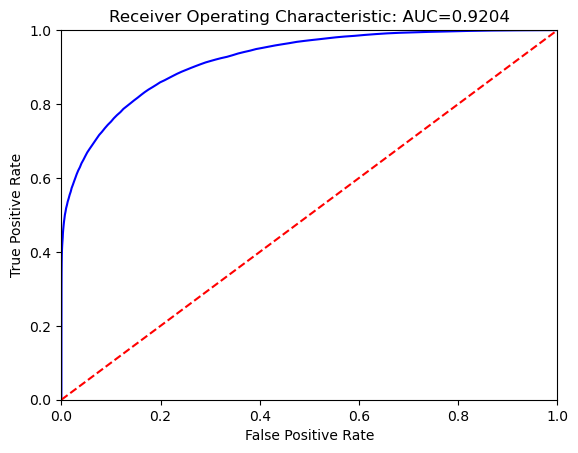

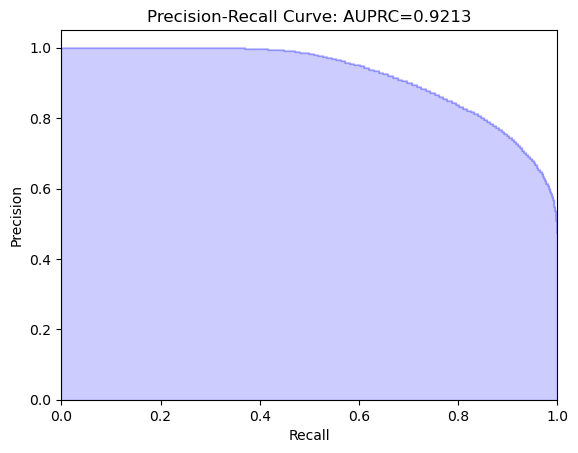

[0.07929413 0.00790577 0.18724586 0.17338412 0.00784003 0.00477348
 0.00729492 0.01380346 0.00454451 0.0145019  0.01908125 0.0006223
 0.00127135 0.0037177  0.04328051 0.04689535 0.02439847 0.02826358
 0.04781644 0.04569789 0.0312183  0.08384004 0.00478486 0.00563663
 0.00334452 0.00032797 0.002493   0.00141912 0.00233492 0.00222036
 0.00211741 0.00264027 0.00235148 0.00364404 0.00206476 0.00204382
 0.00099487 0.0037638  0.00137491 0.00105424 0.00227138 0.00398169
 0.00204507 0.00084045 0.00385004 0.00282857 0.00085584 0.00138714
 0.00060676 0.0058848  0.00186828 0.00163406 0.00502851 0.00690312
 0.00284974 0.00274684 0.00067187 0.00265167 0.00302928 0.00236858
 0.00905361 0.00080581 0.00214627 0.00314317 0.00244782 0.00179179
 0.00500546]


In [208]:
#Single Run
from sklearn.ensemble import RandomForestClassifier
print("Random Forest:")
rf= RandomForestClassifier(random_state=random_seed)
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
importances = rf.feature_importances_
print(importances)
results = ["RF"]
results.extend(result)
results.append(runtime)
result_hospitalization_outcome.append(results)

In [270]:
accuracy = rf.score(X_test, y_test)
print("Accuracy")
print(accuracy)

Accuracy
0.8329705812006697


In [260]:
#All vars + new vars importance

importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
#importance_df.to_csv(os.path.join(path, 'importances_hospitalization_triage_830.csv'))
importance_df.sort_values(by='Importance', axis=0,ascending=False)

,Variable,Importance
2,ed_los_hours,0.187246
3,microbio_event,0.173384
21,triage_acuity,0.083840
0,age,0.079294
18,triage_sbp_knn,0.047816
15,triage_heartrate_knn,0.046895
19,triage_dbp_knn,0.045698
14,triage_temperature_knn,0.043281
20,triage_pain_knn,0.031218
17,triage_o2sat_knn,0.028264


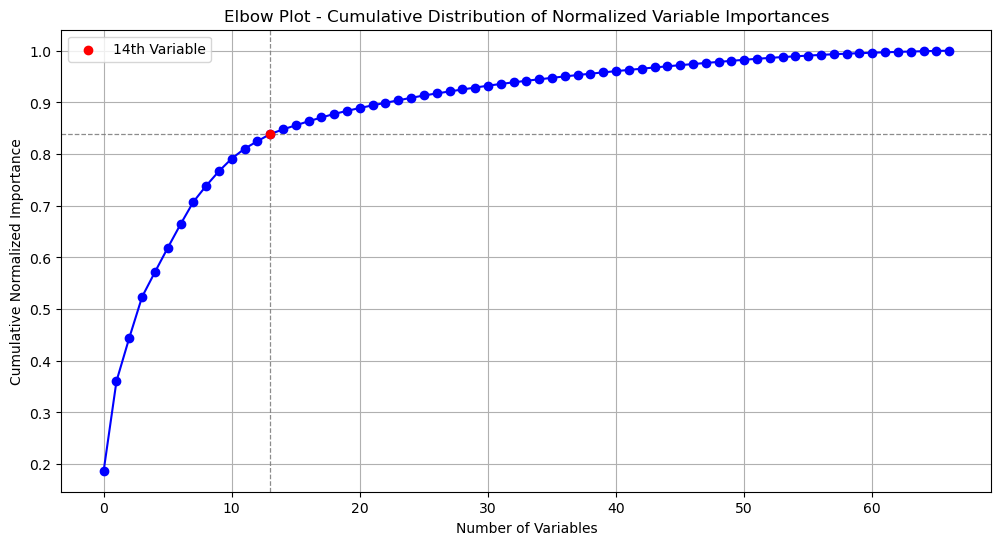

In [102]:
#visualize importances to reduce variables, only include ones with highest importance

# Normalize the importances
importance_df['Normalized_Importance'] = importance_df['Importance'] / importance_df['Importance'].sum()

# Calculate cumulative sum of normalized importances
importance_df['Cumulative_Normalized_Importance'] = importance_df['Normalized_Importance'].cumsum()

# Plot the elbow plot
plt.figure(figsize=(12, 6))
plt.plot(importance_df.index, importance_df['Cumulative_Normalized_Importance'], marker='o', linestyle='-', color='b')
plt.title('Elbow Plot - Cumulative Distribution of Normalized Variable Importances')
plt.xlabel('Number of Variables')
plt.ylabel('Cumulative Normalized Importance')
plt.grid(True)

#Mark the 14th variable point
variable_14_x = 13  # index is 0-based
variable_14_y = importance_df['Cumulative_Normalized_Importance'].iloc[13]

# Add dotted lines
plt.axvline(x=variable_14_x, color='gray', linestyle='--', linewidth=0.9, alpha=0.9)
plt.axhline(y=variable_14_y, color='gray', linestyle='--', linewidth=0.9, alpha=0.9)

# Create a marker at the 14th variable point
plt.scatter(variable_14_x, variable_14_y, color='red', zorder=5,label='14th Variable')  #line
# Add legend
plt.legend()
plt.show()

### Top 14/13 var's 10 folds cv

#### Top 14 new

In [120]:
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve as sklearn_roc_curve
from sklearn.utils import resample
from sklearn.model_selection import cross_val_predict, StratifiedKFold
import numpy as np
import time
from helpers import perform_10_fold_cv
from helpers import PlotROCCurveNew

In [122]:
# Initialize Random Forest Classifier
rf = RandomForestClassifier(random_state=random_seed)

In [124]:
# Top 13 new Perform 10-fold cross-validation with multiple scoring metrics
print("RandomForest:")
start = time.time()
y_probas = cross_val_predict(rf, X_train, y_train, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=random_seed), method='predict_proba')
runtime = time.time() - start
print('Training time:', runtime, 'seconds')

RandomForest:
Training time: 1311.4169340133667 seconds


In [125]:
# Train the model on the entire dataset (top 13 new)
rf.fit(X_train, y_train)

# Extract feature importances
feature_importances = rf.feature_importances_

In [135]:
importance_df = pd.DataFrame(zip(variable, feature_importances), columns=['Variable','Importance'])
#importance_df.to_csv(os.path.join(path, 'importances_critical_triage.csv'))
importance_df.sort_values(by='Importance', axis=0,ascending=False)

,Variable,Importance
0,ed_los_hours,0.220994
1,microbio_event,0.188544
2,triage_acuity,0.094576
3,age,0.092288
4,triage_sbp_knn,0.063322
5,triage_heartrate_knn,0.061307
6,triage_dbp_knn,0.060258
7,triage_temperature_knn,0.056127
8,triage_pain_knn,0.034545
9,triage_o2sat_knn,0.032423


AUC: 0.9161031596418805
AUPRC: 0.917792394832077
Sensitivity: 0.8196022727272727
Specificity: 0.834207993608019
Score thresold: 0.47
2.5 97.5


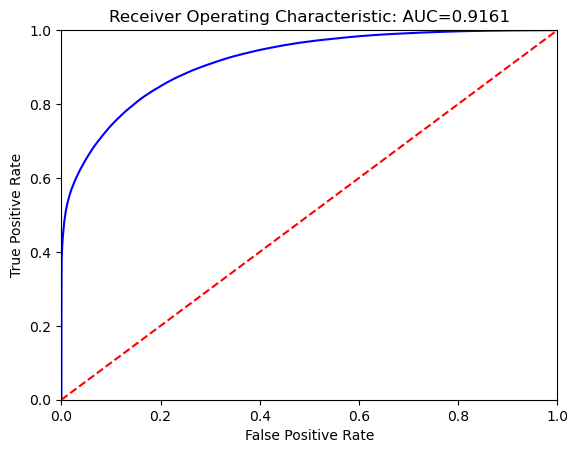

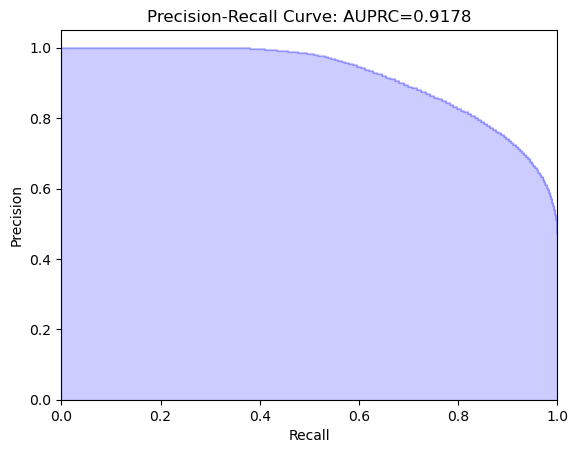

[0.9161031596418805,
 0.917792394832077,
 0.8196022727272727,
 0.834207993608019,
 0.47,
 0.9154236898371034,
 0.9168152110381316,
 0.0004467373940264432,
 0.917151140803644,
 0.9185850291941369,
 0.00048307885731795655,
 0.8177774149358459,
 0.8210897713486316,
 0.000997108752819459,
 0.8334004355411854,
 0.835127248686758,
 0.0005487230650628136]

In [136]:
PlotROCCurveNew(y_probas[:, 1],y_train) 

#### Top 13 old

In [22]:
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve as sklearn_roc_curve
from sklearn.utils import resample
from sklearn.model_selection import cross_val_predict, StratifiedKFold
import numpy as np
import time
from helpers import perform_10_fold_cv
from helpers import PlotROCCurveNew

In [55]:
#print("RandomForest:")
#start = time.time()
#results1 = perform_10_fold_cv(X_train, y_train, random_seed=random_seed)
#runtime = time.time() - start
#print('Training time:', runtime, 'seconds')

RandomForest:
Training time: 1296.0612106323242 seconds


In [43]:
# Initialize Random Forest Classifier
rf = RandomForestClassifier(random_state=random_seed)

In [47]:
# Top 13 old Perform 10-fold cross-validation with multiple scoring metrics
print("RandomForest:")
start = time.time()
y_probas = cross_val_predict(rf, X_train, y_train, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=random_seed), method='predict_proba')
runtime = time.time() - start
print('Training time:', runtime, 'seconds')

RandomForest:
Training time: 1301.1056818962097 seconds


In [51]:
# Train the model on the entire dataset (top 13 old)
rf.fit(X_train, y_train)

# Extract feature importances
feature_importances = rf.feature_importances_

In [54]:
importance_df = pd.DataFrame(zip(variable, feature_importances), columns=['Variable','Importance'])
#importance_df.to_csv(os.path.join(path, 'importances_critical_triage.csv'))
importance_df.sort_values(by='Importance', axis=0,ascending=False)

,Variable,Importance
0,ed_los_hours,0.225411
1,microbio_event,0.193889
3,triage_acuity,0.093770
2,age,0.089302
4,triage_sbp_knn,0.066216
5,triage_heartrate_knn,0.063918
6,triage_dbp_knn,0.062406
7,triage_temperature_knn,0.058138
8,n_hosp_365d,0.036996
9,triage_pain_knn,0.036627


In [66]:
accuracy = rf.score(X_test, y_test)
print("Accuracy")
print(accuracy)

Accuracy
0.9999760822769672


AUC: 0.9142493413353355
AUPRC: 0.9163176486458192
Sensitivity: 0.8156492639922355
Specificity: 0.8328460658446676
Score thresold: 0.47
2.5 97.5


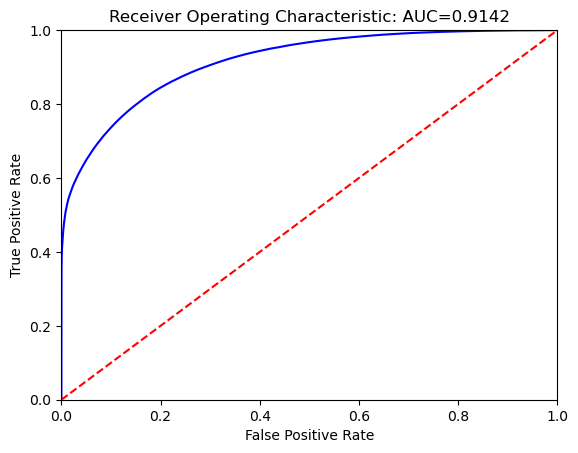

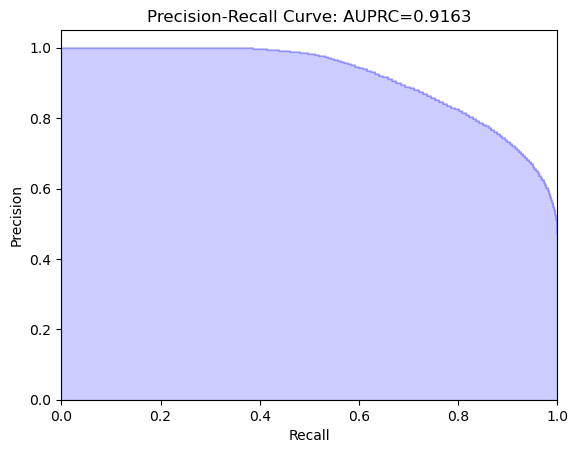

[0.9142493413353355,
 0.9163176486458192,
 0.8156492639922355,
 0.8328460658446676,
 0.47,
 0.9135382719525157,
 0.9149688728687506,
 0.00046898190596036097,
 0.9155791957417109,
 0.9170032363305656,
 0.0005031407700807927,
 0.813666558361776,
 0.8233906446188051,
 0.003368105521168636,
 0.8249652251149898,
 0.8342264073620632,
 0.003409342548402236]

In [58]:
PlotROCCurveNew(y_probas[:, 1],y_train) 

### All variables with 10 folds CV

In [170]:
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve as sklearn_roc_curve
from sklearn.utils import resample
import numpy as np
import time

def perform_10_fold_cv(X, y, random_seed=0):
    # Initialize Random Forest Classifier
    rf = RandomForestClassifier(random_state=random_seed)

    # Perform 10-fold cross-validation with multiple scoring metrics
    y_probas = cross_val_predict(rf, X, y, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=random_seed), method='predict_proba')

    return y_probas

# Example usage
result_list = []

print("RandomForest:")
start = time.time()
results2 = perform_10_fold_cv(X_train, y_train, random_seed=random_seed)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')

#results = ["RF"]
#results.extend(results)
#results.append(runtime)
#result_list.append(results)


RandomForest:
Training time: 1655.028882265091 seconds


In [258]:
results2

array([[0.28, 0.72],
       [0.68, 0.32],
       [0.27, 0.73],
       ...,
       [0.6 , 0.4 ],
       [0.93, 0.07],
       [0.02, 0.98]])

AUC: 0.921099301266049
AUPRC: 0.9218094506349696
Sensitivity: 0.8314461339372371
Specificity: 0.834789082787049
Score thresold: 0.47
2.5 97.5


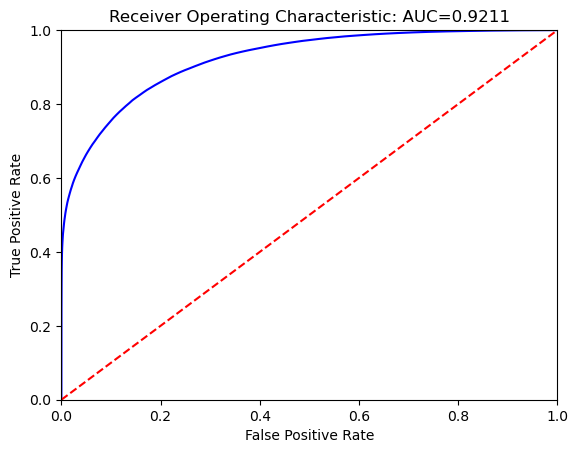

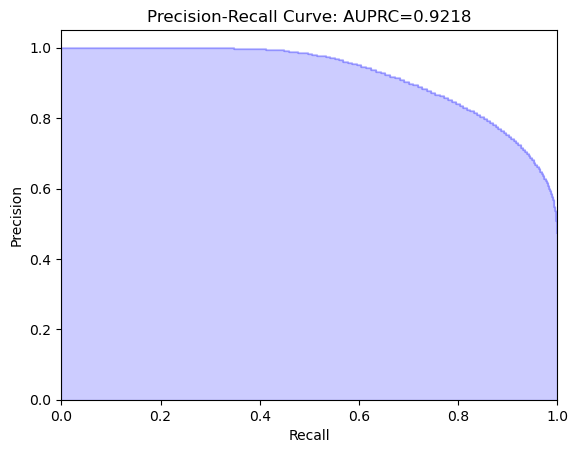

[0.921099301266049,
 0.9218094506349696,
 0.8314461339372371,
 0.834789082787049,
 0.47,
 0.9204599049270252,
 0.921746051346263,
 0.0004354807136430157,
 0.921060137064302,
 0.9224451926208103,
 0.00045640718595029334,
 0.8241544495728067,
 0.8328759251236328,
 0.002378983114836752,
 0.8338032308172428,
 0.8421222640543078,
 0.0022008847839270836]

In [246]:
PlotROCCurveNew(results2[:, 1],y_train)

In [212]:
cuc_with_ci(results2[:, 1],y_train, lower = (100-ci)/2, upper = 100-(100-ci)/2, n_bootstraps=20, rng_seed=random_seed)
#("metric:value,lower,upper,std.dev)  

2.5 97.5


{'AUROC': (0.920530651279346,
  0.9204599049270252,
  0.921746051346263,
  0.0004354807136430157),
 'AP': (0.921060955707457,
  0.921060137064302,
  0.9224451926208103,
  0.00045640718595029334),
 'Sensitivity': (0.831257083873057,
  0.8241544495728067,
  0.8328759251236328,
  0.002378983114836752),
 'Specificity': (0.8335722190975561,
  0.8338032308172428,
  0.8421222640543078,
  0.0022008847839270836)}

In [57]:
from sklearn.metrics import roc_curve as sklearn_roc_curve
from sklearn.metrics import average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import time

In [76]:
all_importances_list = [
    ('ed_los_hours', 0.187246),
    ('microbio_event', 0.173384),
    ('triage_acuity', 0.083840),
    ('age', 0.079294),
    ('triage_sbp_knn', 0.047816),
    ('triage_heartrate_knn', 0.046895),
    ('triage_dbp_knn', 0.045698),
    ('triage_temperature_knn', 0.043281),
    ('triage_pain_knn', 0.031218),
    ('triage_o2sat_knn', 0.028264),
    ('triage_resprate_knn', 0.024398),
    ('n_hosp_365d', 0.019081),
    ('n_hosp_90d', 0.014502),
    ('n_ed_365d', 0.013803),
    ('eci_FluidsLytes', 0.009054),
    ('gender', 0.007906),
    ('med_event', 0.007840),
    ('n_ed_90d', 0.007295),
    ('eci_HTN2', 0.006903),
    ('eci_Arrhythmia', 0.005885),
    ('chiefcom_abdominal_pain', 0.005637),
    ('eci_HTN1', 0.005029),
    ('eci_Depression', 0.005005),
    ('chiefcom_chest_pain', 0.004785),
    ('n_ed_30d', 0.004773),
    ('n_hosp_30d', 0.004545),
    ('cci_DM1', 0.003982),
    ('cci_Renal', 0.003850),
    ('cci_Pulmonary', 0.003764),
    ('n_icu_365d', 0.003718),
    ('cci_CHF', 0.003644),
    ('chiefcom_headache', 0.003345),
    ('eci_Alcohol', 0.003143),
    ('eci_Obesity', 0.003029),
    ('eci_NeuroOther', 0.002850),
    ('cci_Cancer1', 0.002829),
    ('eci_Hypothyroid', 0.002747),
    ('eci_Coagulopathy', 0.002652),
    ('chiefcom_dizziness', 0.002640),
    ('chiefcom_back_pain', 0.002493),
    ('eci_Drugs', 0.002448),
    ('eci_WeightLoss', 0.002369),
    ('cci_MI', 0.002351),
    ('chiefcom_nausea_vomiting', 0.002335),
    ('cci_Liver1', 0.002271),
    ('chiefcom_fever_chills', 0.002220),
    ('eci_Anemia', 0.002146),
    ('chiefcom_syncope', 0.002117),
    ('cci_PVD', 0.002065),
    ('cci_DM2', 0.002045),
    ('cci_Stroke', 0.002044),
    ('eci_Valvular', 0.001868),
    ('eci_Psychoses', 0.001792),
    ('eci_PHTN', 0.001634),
    ('chiefcom_cough', 0.001419),
    ('cci_Cancer2', 0.001387),
    ('cci_Rheumatic', 0.001375),
    ('n_icu_90d', 0.001271),
    ('cci_PUD', 0.001054),
    ('cci_Dementia', 0.000995),
    ('cci_Liver2', 0.000856),
    ('cci_Paralysis', 0.000840),
    ('eci_BloodLoss', 0.000806),
    ('eci_Lymphoma', 0.000672),
    ('n_icu_30d', 0.000622),
    ('cci_HIV', 0.000607),
    ('chiefcom_shortness_of_breath', 0.000328)
]
all_importances_df = pd.DataFrame(all_importances_list, columns=['Variable','Importance'])

In [78]:
all_importances_df

,Variable,Importance
0,ed_los_hours,0.187246
1,microbio_event,0.173384
2,triage_acuity,0.083840
3,age,0.079294
4,triage_sbp_knn,0.047816
5,triage_heartrate_knn,0.046895
6,triage_dbp_knn,0.045698
7,triage_temperature_knn,0.043281
8,triage_pain_knn,0.031218
9,triage_o2sat_knn,0.028264


In [212]:
importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
#importance_df.to_csv(os.path.join(path, 'importances_hospitalization_triage_830.csv'))
importance_df.sort_values(by='Importance', axis=0,ascending=False)

,Variable,Importance
2,ed_los_hours,0.187246
3,microbio_event,0.173384
21,triage_acuity,0.083840
0,age,0.079294
18,triage_sbp_knn,0.047816
15,triage_heartrate_knn,0.046895
19,triage_dbp_knn,0.045698
14,triage_temperature_knn,0.043281
20,triage_pain_knn,0.031218
17,triage_o2sat_knn,0.028264


### Hyperparameter tuning


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import time

# Create a RandomForestClassifier instance
rf = RandomForestClassifier(random_state=random_seed)

# Define a parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
    }

# Create a GridSearchCV instance with cross-validation
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Perform hyperparameter tuning on the training data
start = time.time()
grid_search.fit(X_train, y train)Kernel status: Unknown

runtime = time.time() - start

# Print the best hyperparameters and training time
print('Best hyperparameters:', grid_search.best_params_)
print('Training time:', runtime, 'seconds')

# Get the best trained estimator from GridSearchCV
best_rf = grid_search.best_estimator_

# Predict probabilities on the test set using t he best model
probs = best_rf.predict_proba(X_test)

# Plot ROC curve BB
result = PlotROCCurve(probs[:, 1], y_test, ci=confidence_interval, random_seed=random_seed)

# Get feature importances from the best trained estimator
importances = best_rf.feature_importances_
print(importances)

## Gradient Boosting

### All Variables

GradientBoosting:
Training time: 203.3561728000641 seconds
AUC: 0.9215801515411395
AUPRC: 0.9260703355332653
Sensitivity: 0.8271102459741638
Specificity: 0.8461521004016976
Score thresold: 0.4191081717295158
2.5 97.5


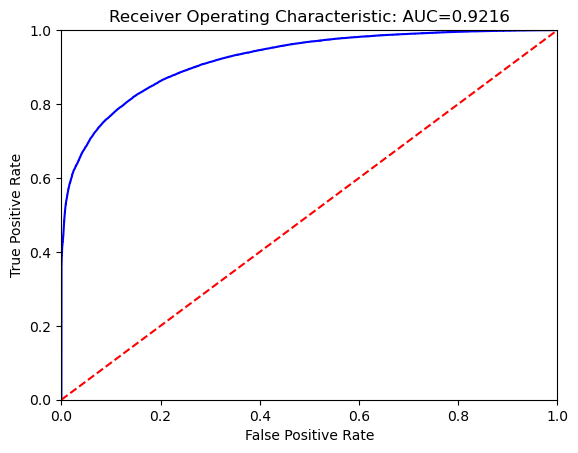

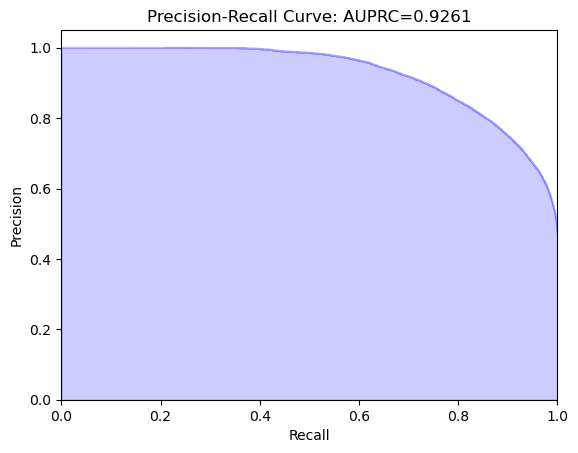

In [ ]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=random_seed)
start = time.time()
gb.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_hospitalization_outcome.append(results)

### 10 folds CV with top 14 var's

In [182]:
## Initialize gb Classifier
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=random_seed)


In [186]:
# Top 13 new Perform 10-fold cross-validation with multiple scoring metrics
print("Gradeint Boosting:")
start = time.time()
y_probas = cross_val_predict(gb, X_train, y_train, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=random_seed), method='predict_proba')
runtime = time.time() - start
print('Training time:', runtime, 'seconds')



Gradeint Boosting:
Training time: 832.3866381645203 seconds


AUC: 0.9182054911429526
AUPRC: 0.92095762791517
Sensitivity: 0.8224431818181818
Specificity: 0.833386297190797
Score thresold: 0.44455572872159377
2.5 97.5


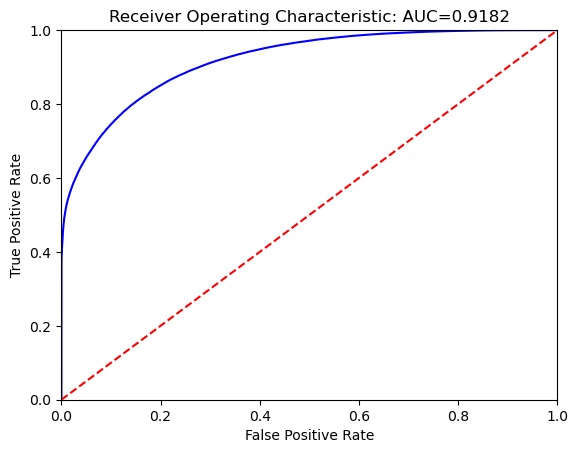

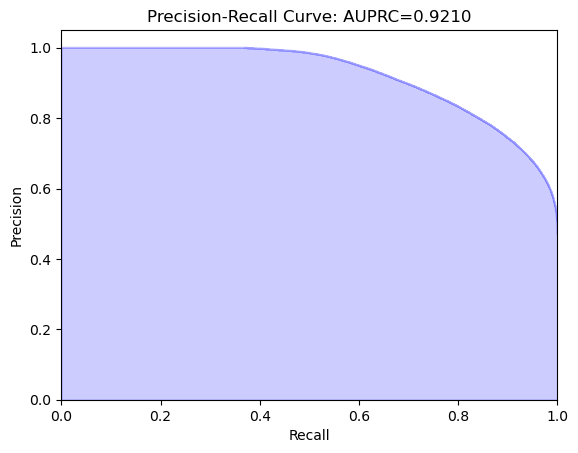

[0.9182054911429526,
 0.92095762791517,
 0.8224431818181818,
 0.833386297190797,
 0.44455572872159377,
 0.9174787615874544,
 0.9189120086122405,
 0.00048199068124152707,
 0.9202424294313077,
 0.9216083489899712,
 0.0004730301837861625,
 0.8190518353065714,
 0.8245321537286288,
 0.0015740282007021312,
 0.8319520481003845,
 0.8366858850551289,
 0.001302709649744059]

In [190]:
PlotROCCurveNew(y_probas[:, 1],y_train) 

## Logistic Regression

### All Variables

Logistic Regression:


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 10.240792274475098 seconds
AUC: 0.9103637396195637
AUPRC: 0.9157887760783852
Sensitivity: 0.8071137851707663
Specificity: 0.8399110364705081
Score thresold: 0.408194905439269
2.5 97.5


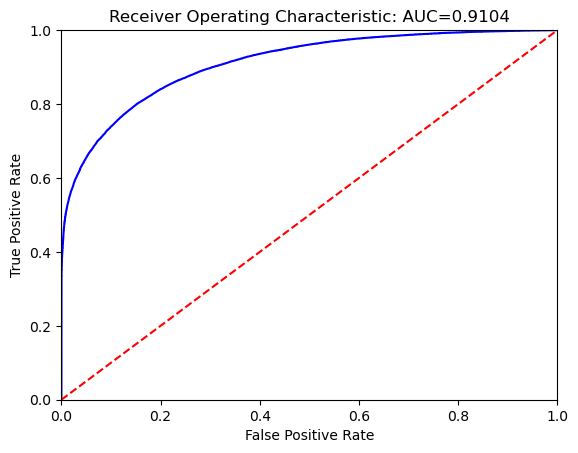

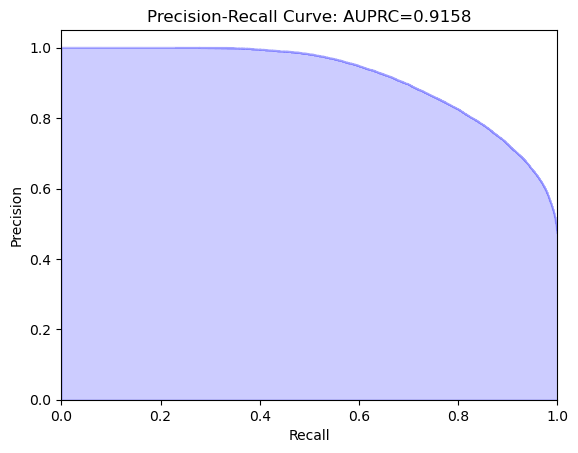

In [ ]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(random_state=random_seed)
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
import pickle
with open('task1_logreg.pickle', 'wb') as model_dump:
    pickle.dump(logreg, model_dump)
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_hospitalization_outcome.append(results)

### top 14 vars

In [215]:
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(random_state=random_seed)

In [217]:
# Top 14 new Perform 10-fold cross-validation with multiple scoring metrics
print("Logistic Regression:")
start = time.time()
y_probas = cross_val_predict(logreg, X_train, y_train, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=random_seed), method='predict_proba')
runtime = time.time() - start
print('Training time:', runtime, 'seconds')

Logistic Regression:


C:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Training time: 36.83353042602539 seconds


C:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC: 0.8960767999209709
AUPRC: 0.8816135052815791
Sensitivity: 0.8135969346489809
Specificity: 0.8145462964644355
Score thresold: 0.44715273109990716
2.5 97.5


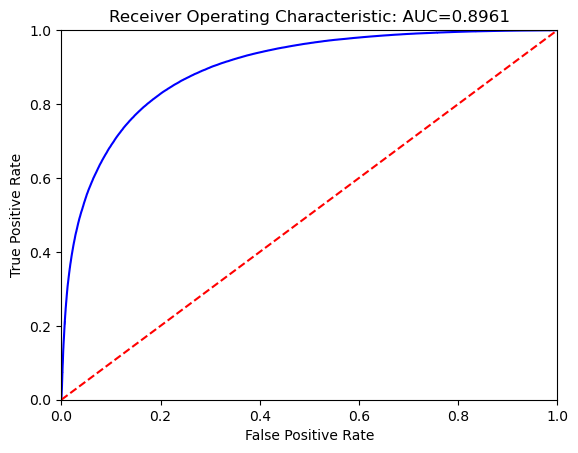

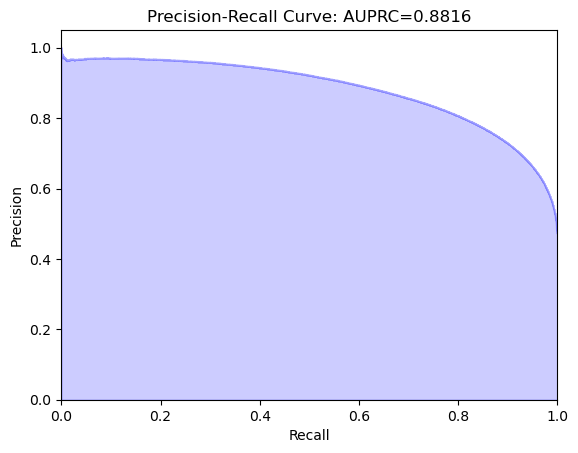

[0.8960767999209709,
 0.8816135052815791,
 0.8135969346489809,
 0.8145462964644355,
 0.44715273109990716,
 0.8952539688232333,
 0.8969391151118594,
 0.00056288718347681,
 0.8805050519567833,
 0.8826242982909852,
 0.0006311421276535482,
 0.811016484695815,
 0.8212734777290891,
 0.0027117102588485255,
 0.8063958639243081,
 0.8169278572704946,
 0.0029614634179607924]

In [219]:
PlotROCCurveNew(y_probas[:, 1],y_train) 

## Deep Learning

In [286]:
class MLP(tf.keras.Model):
    def __init__(self):
        super(MLP, self).__init__()
        self.dense_1 = Dense(128, activation='relu')
        self.dense_2 = Dense(64, activation='relu')
        self.classifier = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.classifier(x)

In [ ]:
# skip this cell if not retraining
mlp = MLP()
mlp.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')},
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train.astype(np.float32), y_train, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
mlp.save('hospitalization_triage_mlp')

Epoch 1/20
1673/1673 [==============================] - 9s 4ms/step - loss: 0.4587 - accuracy: 0.8094 - auc: 0.8835 - auprc: 0.8905 - true_positives: 118733.0000 - true_negatives: 151979.0000 - precision: 0.8305 - recall: 0.7502
Epoch 2/20
1673/1673 [==============================] - 7s 4ms/step - loss: 0.3825 - accuracy: 0.8245 - auc: 0.9036 - auprc: 0.9113 - true_positives: 120991.0000 - true_negatives: 154785.0000 - precision: 0.8495 - recall: 0.7645
Epoch 3/20
1673/1673 [==============================] - 6s 4ms/step - loss: 0.3705 - accuracy: 0.8278 - auc: 0.9092 - auprc: 0.9160 - true_positives: 122165.0000 - true_negatives: 154719.0000 - precision: 0.8504 - recall: 0.7719
Epoch 4/20
1673/1673 [==============================] - 9s 5ms/step - loss: 0.3600 - accuracy: 0.8322 - auc: 0.9141 - auprc: 0.9203 - true_positives: 123443.0000 - true_negatives: 154925.0000 - precision: 0.8529 - recall: 0.7800
Epoch 5/20
1673/1673 [==============================] - 7s 4ms/step - loss: 0.3572 -

INFO:tensorflow:Assets written to: hospitalization_triage_mlp\assets


MLP:
2614/2614 [==============================] - 5s 2ms/step
AUC: 0.926823179379857
AUPRC: 0.9310240449064671
Sensitivity: 0.8303208028920293
Specificity: 0.8556158227991739
Score thresold: 0.44332168
2.5 97.5


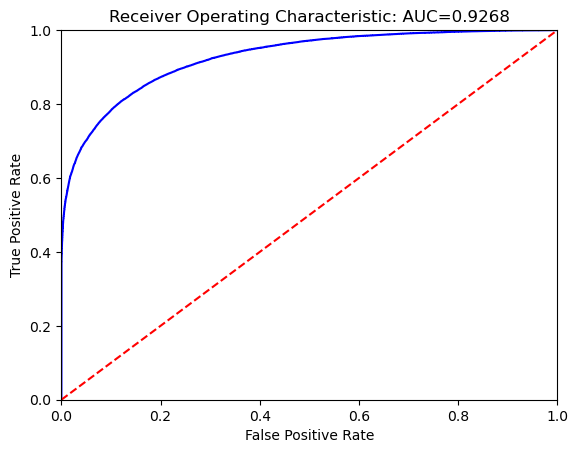

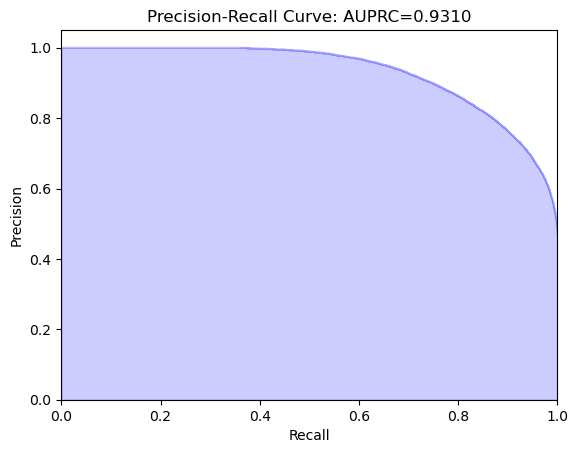

In [ ]:
print("MLP:")
mlp = load_model('hospitalization_triage_mlp')
probs = mlp.predict(X_test.astype(np.float32))
result = PlotROCCurve(probs,y_test, ci=confidence_interval, random_seed=random_seed)
results = ["MLP"]
results.extend(result)
results.append(runtime)
result_hospitalization_outcome.append(results)

### 10 folds cv with top 14 vars 

In [282]:
X = np.array(X_train)
y = np.array(y_train)

In [303]:
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report

# Function to perform 10-fold cross-validation for MLP
def perform_10_fold_cv_mlp_new(X, y, random_seed=0):
    X = np.array(X)
    y = np.array(y)
    
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_seed)
    result_list = []

    all_aurocs = []
    all_auprcs = []
    all_sensitivities = []
    all_specificities = []
    all_runtimes = []

    for train_index, test_index in skf.split(X, y):
        X_train_fold, X_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]

        mlp = MLP()
        mlp.compile(loss='binary_crossentropy',
                    optimizer=Adam(learning_rate=0.001),
                    metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')},
                             'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])

        start = time.time()
        mlp.fit(X_train_fold.astype(np.float32), y_train_fold, batch_size=200, epochs=20)
        runtime = time.time() - start

        # Predict probabilities for the positive class
        probs_fold = mlp.predict(X_test_fold.astype(np.float32))

        # Compute AUROC and AUPRC for the current fold
        auroc = roc_auc_score(y_test_fold, probs_fold)
        auprc = average_precision_score(y_test_fold, probs_fold)

        # Print classification report for sensitivity, specificity, etc.
        y_pred = (probs_fold > 0.5).astype(int)
        report = classification_report(y_test_fold, y_pred, output_dict=True)

        # Check if labels '1' and '0' exist in the classification report
        sensitivity = report.get('1', {}).get('recall', 0.0)
        specificity = report.get('0', {}).get('recall', 0.0)

        # Plot ROC curve for the current fold
        result_fold = PlotROCCurve(probs_fold, y_test_fold, ci=confidence_interval, random_seed=random_seed)

        # Accumulate results for this fold
        all_aurocs.append(auroc)
        all_auprcs.append(auprc)
        all_sensitivities.append(sensitivity)
        all_specificities.append(specificity)
        all_runtimes.append(runtime)

    # Compute the mean and standard deviation of aggregated results
    mean_auroc = np.mean(all_aurocs)
    std_auroc = np.std(all_aurocs)
    mean_auprc = np.mean(all_auprcs)
    std_auprc = np.std(all_auprcs)
    mean_sensitivity = np.mean(all_sensitivities)
    std_sensitivity = np.std(all_sensitivities)
    mean_specificity = np.mean(all_specificities)
    std_specificity = np.std(all_specificities)
    mean_runtime = np.mean(all_runtimes)

    # Display or store the aggregated results as needed
    print("Mean AUROC:", mean_auroc)
    print("Standard Deviation AUROC:", std_auroc)
    print("Mean AUPRC:", mean_auprc)
    print("Standard Deviation AUPRC:", std_auprc)
    print("Mean Sensitivity:", mean_sensitivity)
    print("Standard Deviation Sensitivity:", std_sensitivity)
    print("Mean Specificity:", mean_specificity)
    print("Standard Deviation Specificity:", std_specificity)
    print("Mean Runtime:", mean_runtime)

    return result_list


Epoch 1/20
1882/1882 [==============================] - 7s 3ms/step - loss: 0.4304 - accuracy: 0.7976 - auc: 0.8817 - auprc: 0.8803 - true_positives: 133479.0000 - true_negatives: 166650.0000 - precision: 0.8086 - recall: 0.7497
Epoch 2/20
1882/1882 [==============================] - 5s 2ms/step - loss: 0.3819 - accuracy: 0.8164 - auc: 0.9042 - auprc: 0.9084 - true_positives: 136087.0000 - true_negatives: 171108.0000 - precision: 0.8337 - recall: 0.7644
Epoch 3/20
1882/1882 [==============================] - 7s 4ms/step - loss: 0.3725 - accuracy: 0.8196 - auc: 0.9084 - auprc: 0.9125 - true_positives: 136753.0000 - true_negatives: 171669.0000 - precision: 0.8373 - recall: 0.7681
Epoch 4/20
1882/1882 [==============================] - 9s 5ms/step - loss: 0.3691 - accuracy: 0.8203 - auc: 0.9095 - auprc: 0.9137 - true_positives: 137373.0000 - true_negatives: 171284.0000 - precision: 0.8359 - recall: 0.7716
Epoch 5/20
1882/1882 [==============================] - 5s 3ms/step - loss: 0.3647 -

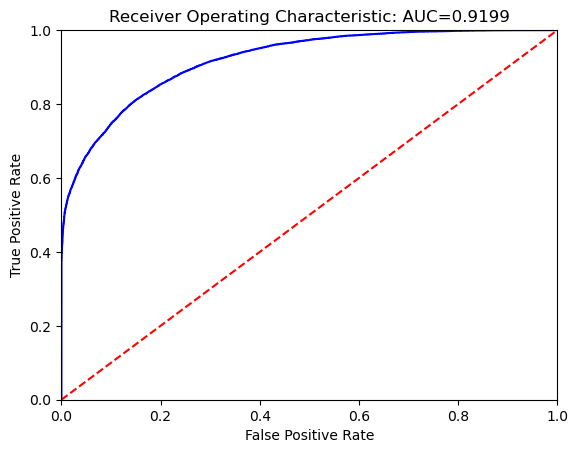

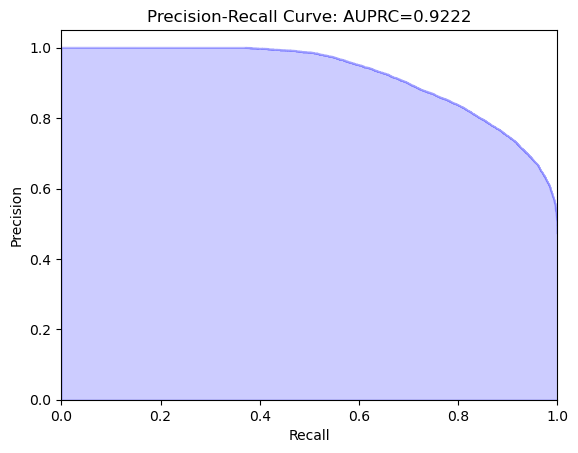

Epoch 1/20
1882/1882 [==============================] - 6s 2ms/step - loss: 0.4393 - accuracy: 0.7998 - auc: 0.8826 - auprc: 0.8773 - true_positives: 134129.0000 - true_negatives: 166821.0000 - precision: 0.8102 - recall: 0.7534
Epoch 2/20
1882/1882 [==============================] - 5s 2ms/step - loss: 0.3786 - accuracy: 0.8176 - auc: 0.9057 - auprc: 0.9098 - true_positives: 137224.0000 - true_negatives: 170445.0000 - precision: 0.8315 - recall: 0.7707
Epoch 3/20
1882/1882 [==============================] - 5s 3ms/step - loss: 0.3737 - accuracy: 0.8189 - auc: 0.9075 - auprc: 0.9118 - true_positives: 137218.0000 - true_negatives: 170912.0000 - precision: 0.8339 - recall: 0.7707
Epoch 4/20
1882/1882 [==============================] - 5s 2ms/step - loss: 0.3699 - accuracy: 0.8204 - auc: 0.9091 - auprc: 0.9133 - true_positives: 137629.0000 - true_negatives: 171089.0000 - precision: 0.8352 - recall: 0.7730
Epoch 5/20
1882/1882 [==============================] - 7s 4ms/step - loss: 0.3645 -

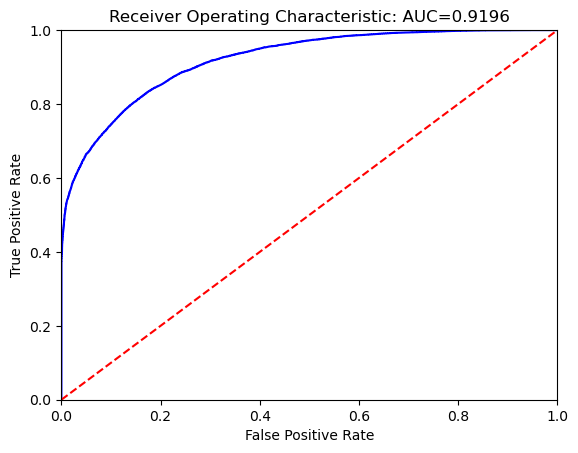

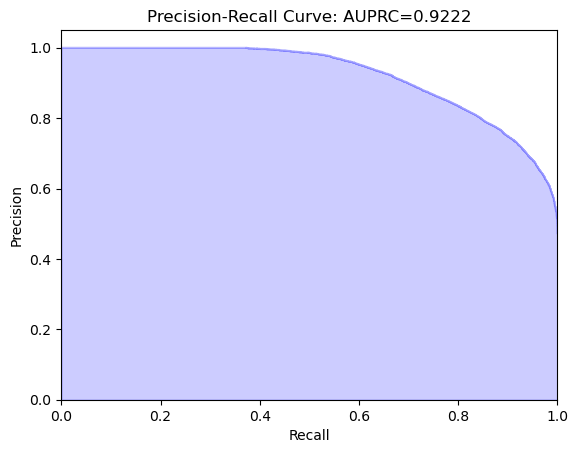

Epoch 1/20
1882/1882 [==============================] - 7s 3ms/step - loss: 0.4246 - accuracy: 0.8023 - auc: 0.8859 - auprc: 0.8842 - true_positives: 134976.0000 - true_negatives: 166930.0000 - precision: 0.8117 - recall: 0.7581
Epoch 2/20
1882/1882 [==============================] - 5s 2ms/step - loss: 0.3809 - accuracy: 0.8159 - auc: 0.9046 - auprc: 0.9092 - true_positives: 136573.0000 - true_negatives: 170451.0000 - precision: 0.8309 - recall: 0.7671
Epoch 3/20
1882/1882 [==============================] - 5s 2ms/step - loss: 0.3742 - accuracy: 0.8185 - auc: 0.9073 - auprc: 0.9119 - true_positives: 136951.0000 - true_negatives: 171058.0000 - precision: 0.8343 - recall: 0.7692
Epoch 4/20
1882/1882 [==============================] - 5s 3ms/step - loss: 0.3689 - accuracy: 0.8201 - auc: 0.9097 - auprc: 0.9138 - true_positives: 137299.0000 - true_negatives: 171313.0000 - precision: 0.8360 - recall: 0.7712
Epoch 5/20
1882/1882 [==============================] - 6s 3ms/step - loss: 0.3665 -

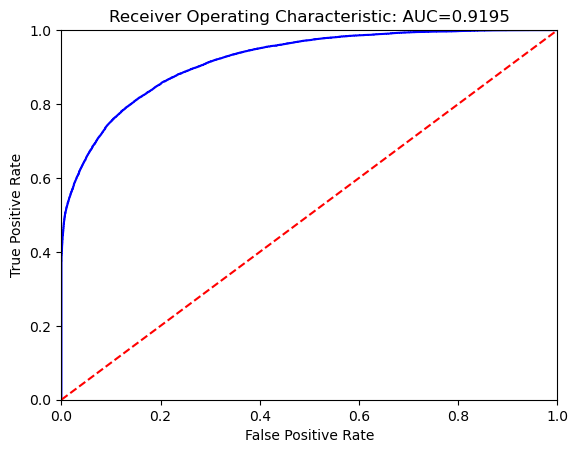

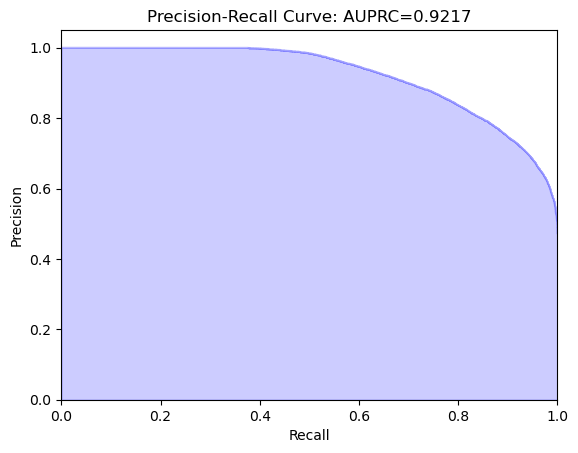

Epoch 1/20
1882/1882 [==============================] - 7s 3ms/step - loss: 0.4412 - accuracy: 0.7969 - auc: 0.8798 - auprc: 0.8782 - true_positives: 133600.0000 - true_negatives: 166283.0000 - precision: 0.8069 - recall: 0.7504
Epoch 2/20
1882/1882 [==============================] - 5s 2ms/step - loss: 0.3877 - accuracy: 0.8144 - auc: 0.9018 - auprc: 0.9066 - true_positives: 135813.0000 - true_negatives: 170649.0000 - precision: 0.8311 - recall: 0.7628
Epoch 3/20
1882/1882 [==============================] - 5s 2ms/step - loss: 0.3811 - accuracy: 0.8168 - auc: 0.9044 - auprc: 0.9094 - true_positives: 136322.0000 - true_negatives: 171015.0000 - precision: 0.8335 - recall: 0.7657
Epoch 4/20
1882/1882 [==============================] - 5s 2ms/step - loss: 0.3774 - accuracy: 0.8178 - auc: 0.9059 - auprc: 0.9108 - true_positives: 136698.0000 - true_negatives: 171044.0000 - precision: 0.8340 - recall: 0.7678
Epoch 5/20
1882/1882 [==============================] - 5s 3ms/step - loss: 0.3705 -

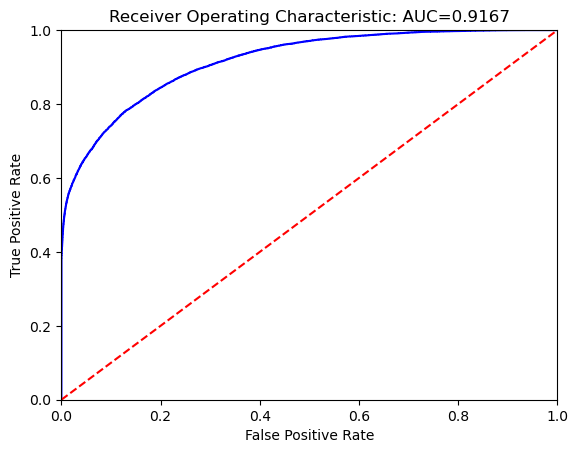

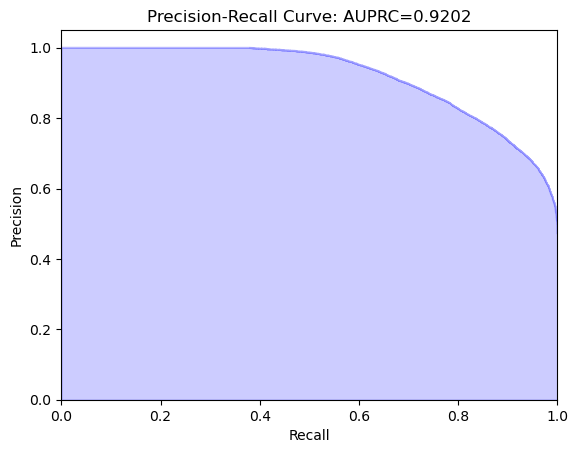

Epoch 1/20
1882/1882 [==============================] - 6s 2ms/step - loss: 0.4372 - accuracy: 0.8012 - auc: 0.8824 - auprc: 0.8788 - true_positives: 133494.0000 - true_negatives: 167977.0000 - precision: 0.8152 - recall: 0.7498
Epoch 2/20
1882/1882 [==============================] - 5s 2ms/step - loss: 0.3808 - accuracy: 0.8173 - auc: 0.9049 - auprc: 0.9091 - true_positives: 136096.0000 - true_negatives: 171431.0000 - precision: 0.8354 - recall: 0.7644
Epoch 3/20
1882/1882 [==============================] - 5s 3ms/step - loss: 0.3747 - accuracy: 0.8187 - auc: 0.9074 - auprc: 0.9118 - true_positives: 136624.0000 - true_negatives: 171449.0000 - precision: 0.8360 - recall: 0.7674
Epoch 4/20
1882/1882 [==============================] - 5s 2ms/step - loss: 0.3704 - accuracy: 0.8208 - auc: 0.9094 - auprc: 0.9134 - true_positives: 137248.0000 - true_negatives: 171600.0000 - precision: 0.8374 - recall: 0.7709
Epoch 5/20
1882/1882 [==============================] - 5s 3ms/step - loss: 0.3676 -

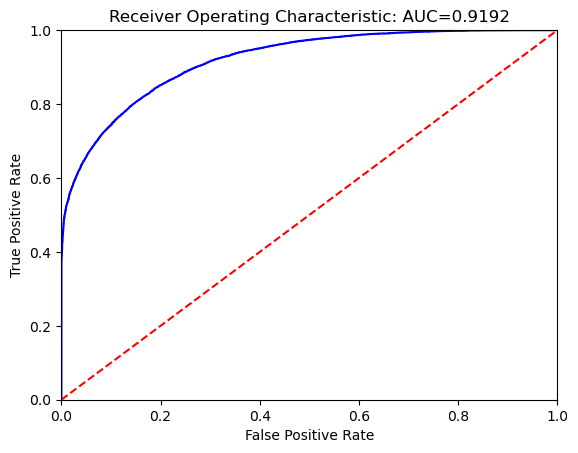

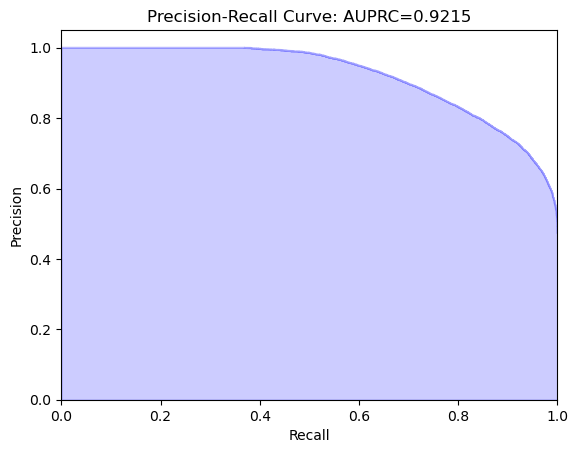

Epoch 1/20
1882/1882 [==============================] - 8s 3ms/step - loss: 0.4280 - accuracy: 0.8019 - auc: 0.8853 - auprc: 0.8824 - true_positives: 134646.0000 - true_negatives: 167088.0000 - precision: 0.8121 - recall: 0.7563
Epoch 2/20
1882/1882 [==============================] - 5s 3ms/step - loss: 0.3800 - accuracy: 0.8172 - auc: 0.9053 - auprc: 0.9092 - true_positives: 137090.0000 - true_negatives: 170397.0000 - precision: 0.8311 - recall: 0.7700
Epoch 3/20
1882/1882 [==============================] - 5s 3ms/step - loss: 0.3741 - accuracy: 0.8189 - auc: 0.9075 - auprc: 0.9118 - true_positives: 137520.0000 - true_negatives: 170613.0000 - precision: 0.8327 - recall: 0.7724
Epoch 4/20
1882/1882 [==============================] - 5s 3ms/step - loss: 0.3672 - accuracy: 0.8211 - auc: 0.9105 - auprc: 0.9145 - true_positives: 138051.0000 - true_negatives: 170926.0000 - precision: 0.8348 - recall: 0.7754
Epoch 5/20
1882/1882 [==============================] - 5s 2ms/step - loss: 0.3643 -

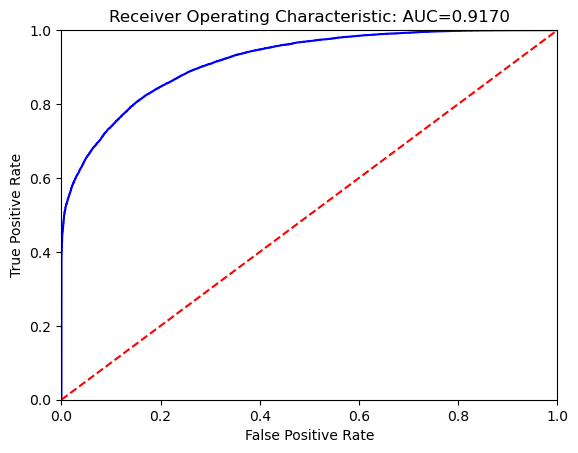

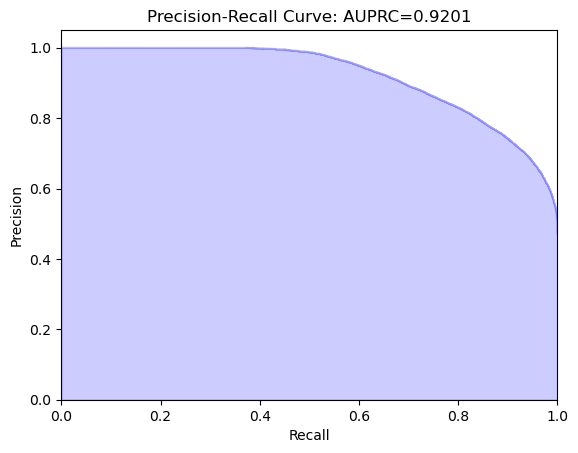

Epoch 1/20
1882/1882 [==============================] - 6s 3ms/step - loss: 0.4254 - accuracy: 0.8028 - auc: 0.8863 - auprc: 0.8839 - true_positives: 134202.0000 - true_negatives: 167898.0000 - precision: 0.8156 - recall: 0.7538
Epoch 2/20
1882/1882 [==============================] - 5s 3ms/step - loss: 0.3796 - accuracy: 0.8172 - auc: 0.9052 - auprc: 0.9093 - true_positives: 136621.0000 - true_negatives: 170882.0000 - precision: 0.8331 - recall: 0.7674
Epoch 3/20
1882/1882 [==============================] - 5s 3ms/step - loss: 0.3719 - accuracy: 0.8201 - auc: 0.9086 - auprc: 0.9127 - true_positives: 137281.0000 - true_negatives: 171306.0000 - precision: 0.8359 - recall: 0.7711
Epoch 4/20
1882/1882 [==============================] - 5s 3ms/step - loss: 0.3699 - accuracy: 0.8199 - auc: 0.9093 - auprc: 0.9134 - true_positives: 137633.0000 - true_negatives: 170876.0000 - precision: 0.8341 - recall: 0.7730
Epoch 5/20
1882/1882 [==============================] - 5s 3ms/step - loss: 0.3653 -

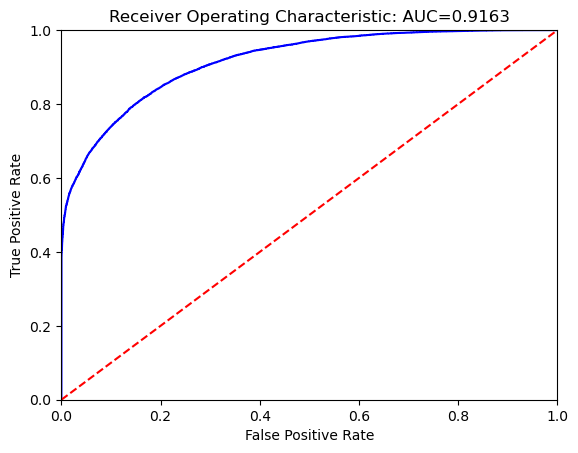

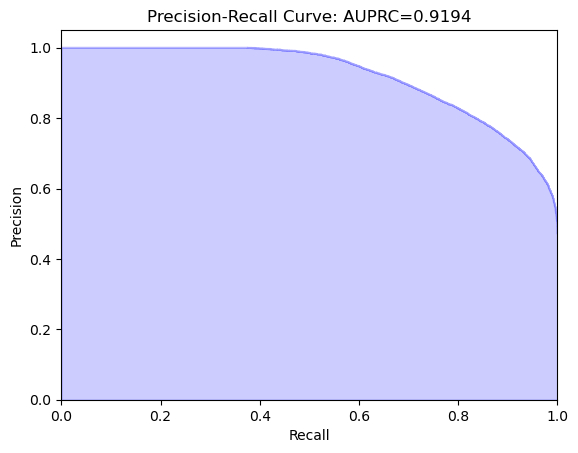

Epoch 1/20
1882/1882 [==============================] - 6s 3ms/step - loss: 0.4594 - accuracy: 0.7975 - auc: 0.8796 - auprc: 0.8734 - true_positives: 133766.0000 - true_negatives: 166312.0000 - precision: 0.8073 - recall: 0.7513
Epoch 2/20
1882/1882 [==============================] - 5s 3ms/step - loss: 0.3832 - accuracy: 0.8164 - auc: 0.9039 - auprc: 0.9079 - true_positives: 136823.0000 - true_negatives: 170363.0000 - precision: 0.8307 - recall: 0.7685
Epoch 3/20
1882/1882 [==============================] - 5s 3ms/step - loss: 0.3741 - accuracy: 0.8192 - auc: 0.9078 - auprc: 0.9119 - true_positives: 137419.0000 - true_negatives: 170827.0000 - precision: 0.8336 - recall: 0.7718
Epoch 4/20
1882/1882 [==============================] - 5s 2ms/step - loss: 0.3688 - accuracy: 0.8215 - auc: 0.9102 - auprc: 0.9140 - true_positives: 137900.0000 - true_negatives: 171206.0000 - precision: 0.8360 - recall: 0.7745
Epoch 5/20
1882/1882 [==============================] - 5s 2ms/step - loss: 0.3662 -

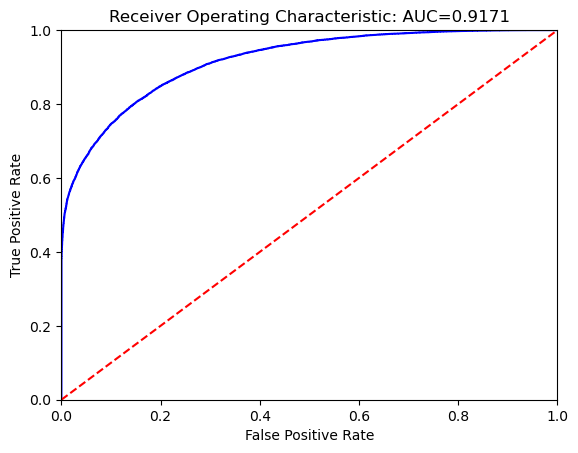

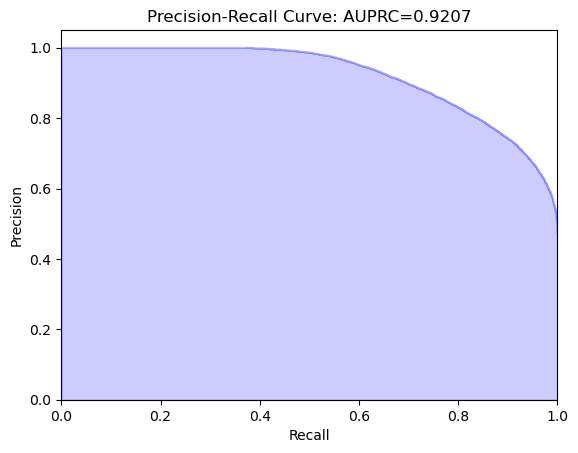

Epoch 1/20
1882/1882 [==============================] - 8s 3ms/step - loss: 0.4335 - accuracy: 0.8039 - auc: 0.8863 - auprc: 0.8818 - true_positives: 135441.0000 - true_negatives: 167068.0000 - precision: 0.8129 - recall: 0.7607
Epoch 2/20
1882/1882 [==============================] - 5s 3ms/step - loss: 0.3752 - accuracy: 0.8186 - auc: 0.9076 - auprc: 0.9112 - true_positives: 137397.0000 - true_negatives: 170650.0000 - precision: 0.8327 - recall: 0.7717
Epoch 3/20
1882/1882 [==============================] - 5s 2ms/step - loss: 0.3712 - accuracy: 0.8203 - auc: 0.9090 - auprc: 0.9130 - true_positives: 137805.0000 - true_negatives: 170877.0000 - precision: 0.8343 - recall: 0.7740
Epoch 4/20
1882/1882 [==============================] - 5s 3ms/step - loss: 0.3664 - accuracy: 0.8222 - auc: 0.9111 - auprc: 0.9149 - true_positives: 138184.0000 - true_negatives: 171213.0000 - precision: 0.8364 - recall: 0.7761
Epoch 5/20
1882/1882 [==============================] - 5s 3ms/step - loss: 0.3640 -

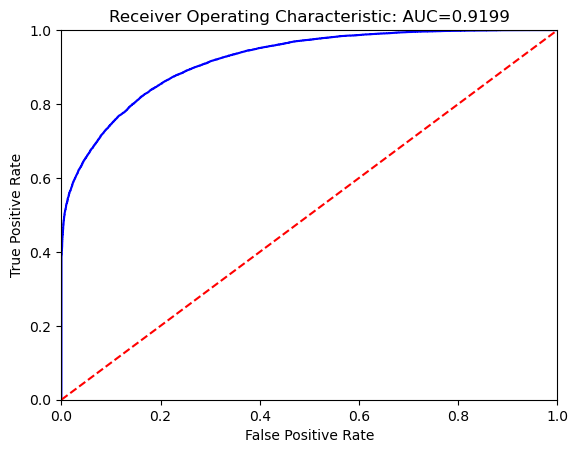

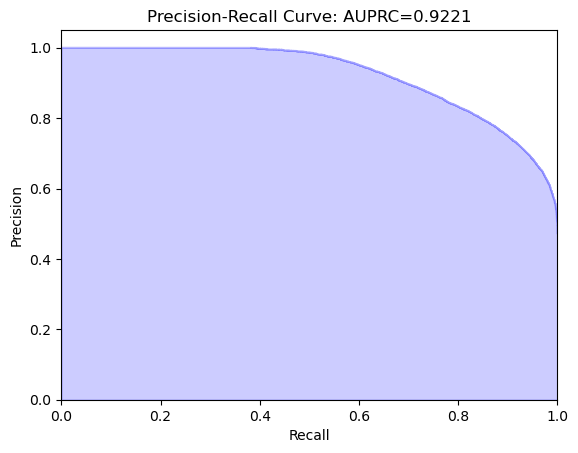

Epoch 1/20
1882/1882 [==============================] - 6s 2ms/step - loss: 0.4813 - accuracy: 0.7988 - auc: 0.8784 - auprc: 0.8688 - true_positives: 134296.0000 - true_negatives: 166267.0000 - precision: 0.8077 - recall: 0.7543
Epoch 2/20
1882/1882 [==============================] - 5s 3ms/step - loss: 0.3833 - accuracy: 0.8158 - auc: 0.9038 - auprc: 0.9079 - true_positives: 136854.0000 - true_negatives: 170137.0000 - precision: 0.8296 - recall: 0.7687
Epoch 3/20
1882/1882 [==============================] - 6s 3ms/step - loss: 0.3719 - accuracy: 0.8200 - auc: 0.9087 - auprc: 0.9126 - true_positives: 137740.0000 - true_negatives: 170800.0000 - precision: 0.8338 - recall: 0.7736
Epoch 4/20
1882/1882 [==============================] - 5s 2ms/step - loss: 0.3701 - accuracy: 0.8201 - auc: 0.9093 - auprc: 0.9134 - true_positives: 137779.0000 - true_negatives: 170807.0000 - precision: 0.8339 - recall: 0.7739
Epoch 5/20
1882/1882 [==============================] - 5s 3ms/step - loss: 0.3652 -

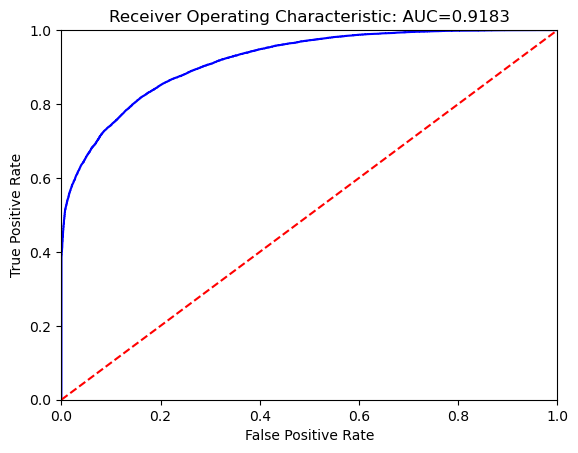

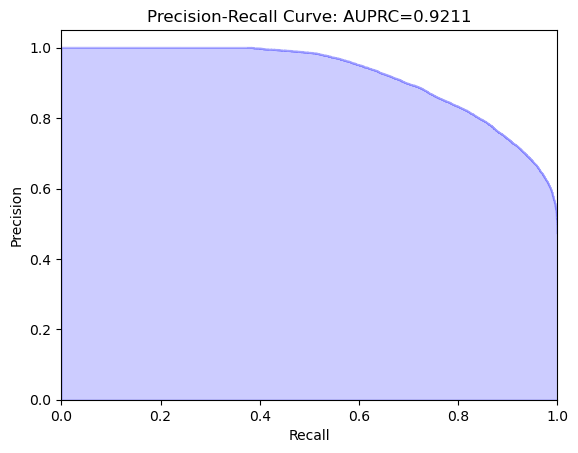

Mean AUROC: 0.9183311214897317
Standard Deviation AUROC: 0.001372656881380194
Mean AUPRC: 0.9211106025064859
Standard Deviation AUPRC: 0.0009500381427600073
Mean Sensitivity: 0.0
Standard Deviation Sensitivity: 0.0
Mean Specificity: 0.0
Standard Deviation Specificity: 0.0
Mean Runtime: 103.21724758148193


[]

In [305]:
perform_10_fold_cv_mlp_new(X_train, y_train, random_seed=random_seed)

In [272]:
# Function to perform 10-fold cross-validation for MLP
def perform_10_fold_cv_mlp(X, y, random_seed=0):
    X = np.array(X)
    y = np.array(y)
    
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_seed)
    result_list = []

    for train_index, test_index in skf.split(X, y):
        X_train_fold, X_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]

        mlp = MLP()
        mlp.compile(loss='binary_crossentropy',
                    optimizer=Adam(learning_rate=0.001),
                    metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')},
                             'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])

        start = time.time()
        mlp.fit(X_train_fold.astype(np.float32), y_train_fold, batch_size=200, epochs=20)
        runtime = time.time() - start

      
         # Predict probabilities for the positive class
        probs_fold = mlp.predict(X_test_fold.astype(np.float32))

        # Plot ROC curve for the current fold
        result_fold = PlotROCCurve(probs_fold, y_test_fold, ci=confidence_interval, random_seed=random_seed)

        results = ["MLP"]
        results.extend(result_fold)
        results.append(runtime)
        result_list.append(results)

    return result_list

Epoch 1/20
1882/1882 [==============================] - 7s 3ms/step - loss: 0.4578 - accuracy: 0.7989 - auc: 0.8800 - auprc: 0.8721 - true_positives: 134153.0000 - true_negatives: 166460.0000 - precision: 0.8084 - recall: 0.7535
Epoch 2/20
1882/1882 [==============================] - 5s 3ms/step - loss: 0.3785 - accuracy: 0.8175 - auc: 0.9057 - auprc: 0.9098 - true_positives: 136944.0000 - true_negatives: 170661.0000 - precision: 0.8323 - recall: 0.7692
Epoch 3/20
1882/1882 [==============================] - 5s 3ms/step - loss: 0.3729 - accuracy: 0.8192 - auc: 0.9081 - auprc: 0.9121 - true_positives: 137482.0000 - true_negatives: 170792.0000 - precision: 0.8335 - recall: 0.7722
Epoch 4/20
1882/1882 [==============================] - 5s 3ms/step - loss: 0.3679 - accuracy: 0.8213 - auc: 0.9102 - auprc: 0.9141 - true_positives: 137740.0000 - true_negatives: 171303.0000 - precision: 0.8364 - recall: 0.7736
Epoch 5/20
1882/1882 [==============================] - 5s 3ms/step - loss: 0.3647 -

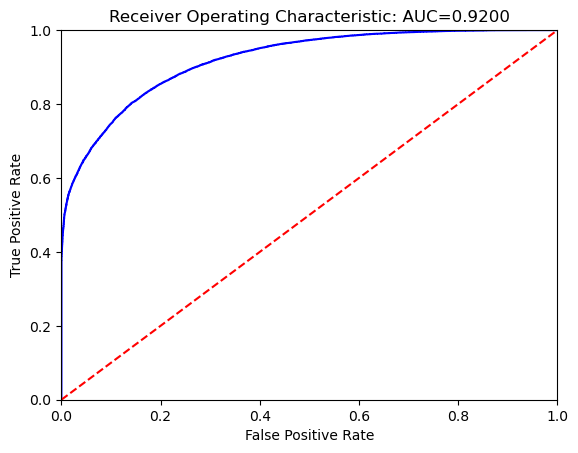

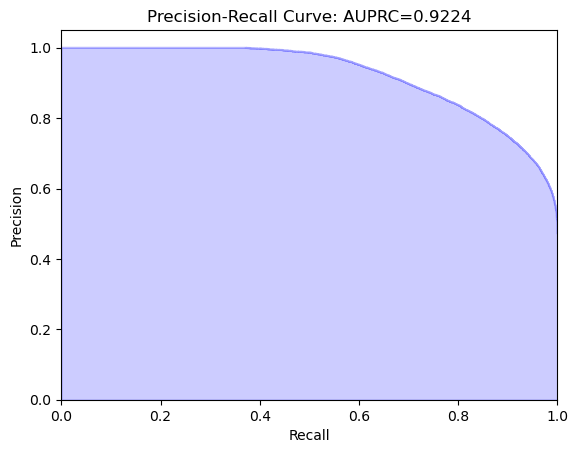

Epoch 1/20
1882/1882 [==============================] - 7s 3ms/step - loss: 0.4350 - accuracy: 0.8019 - auc: 0.8845 - auprc: 0.8798 - true_positives: 134174.0000 - true_negatives: 167576.0000 - precision: 0.8139 - recall: 0.7536
Epoch 2/20
1882/1882 [==============================] - 6s 3ms/step - loss: 0.3821 - accuracy: 0.8160 - auc: 0.9042 - auprc: 0.9084 - true_positives: 135911.0000 - true_negatives: 171147.0000 - precision: 0.8337 - recall: 0.7634
Epoch 3/20
1882/1882 [==============================] - 5s 3ms/step - loss: 0.3755 - accuracy: 0.8189 - auc: 0.9071 - auprc: 0.9114 - true_positives: 136825.0000 - true_negatives: 171318.0000 - precision: 0.8355 - recall: 0.7685
Epoch 4/20
1882/1882 [==============================] - 5s 3ms/step - loss: 0.3700 - accuracy: 0.8209 - auc: 0.9095 - auprc: 0.9135 - true_positives: 137405.0000 - true_negatives: 171501.0000 - precision: 0.8371 - recall: 0.7718
Epoch 5/20
1882/1882 [==============================] - 6s 3ms/step - loss: 0.3665 -

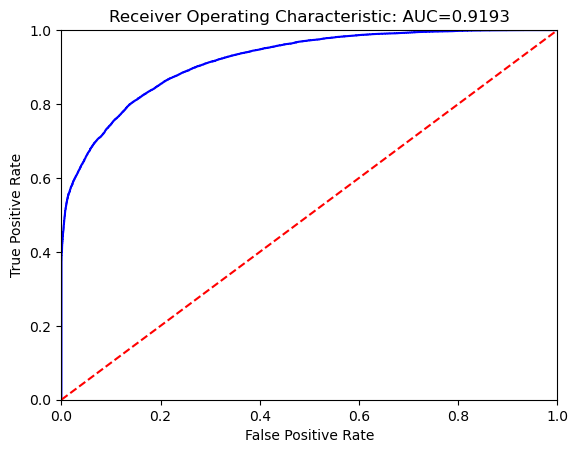

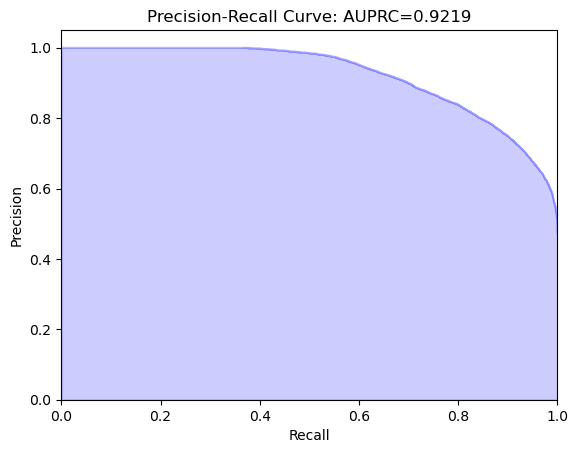

Epoch 1/20
1882/1882 [==============================] - 7s 3ms/step - loss: 0.4238 - accuracy: 0.8006 - auc: 0.8849 - auprc: 0.8839 - true_positives: 134208.0000 - true_negatives: 167031.0000 - precision: 0.8113 - recall: 0.7538
Epoch 2/20
1882/1882 [==============================] - 5s 2ms/step - loss: 0.3814 - accuracy: 0.8167 - auc: 0.9045 - auprc: 0.9085 - true_positives: 136250.0000 - true_negatives: 171052.0000 - precision: 0.8336 - recall: 0.7653
Epoch 3/20
1882/1882 [==============================] - 5s 3ms/step - loss: 0.3742 - accuracy: 0.8192 - auc: 0.9076 - auprc: 0.9117 - true_positives: 136807.0000 - true_negatives: 171454.0000 - precision: 0.8362 - recall: 0.7684
Epoch 4/20
1882/1882 [==============================] - 6s 3ms/step - loss: 0.3707 - accuracy: 0.8204 - auc: 0.9089 - auprc: 0.9131 - true_positives: 137429.0000 - true_negatives: 171288.0000 - precision: 0.8360 - recall: 0.7719
Epoch 5/20
1882/1882 [==============================] - 5s 3ms/step - loss: 0.3658 -

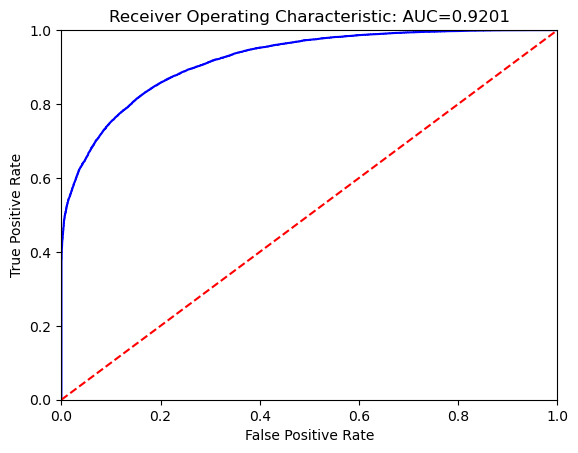

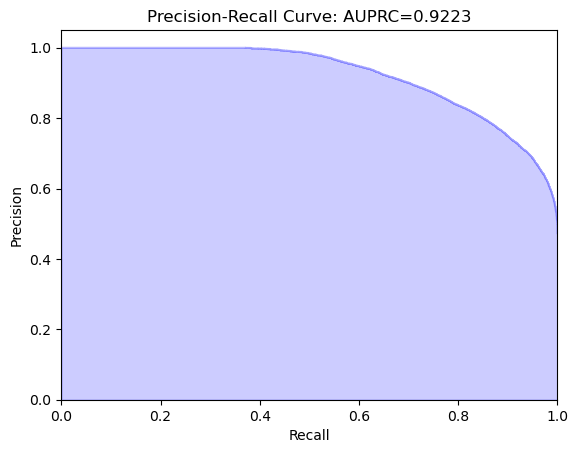

Epoch 1/20
1882/1882 [==============================] - 7s 3ms/step - loss: 0.4367 - accuracy: 0.7995 - auc: 0.8817 - auprc: 0.8777 - true_positives: 134157.0000 - true_negatives: 166705.0000 - precision: 0.8096 - recall: 0.7535
Epoch 2/20
1882/1882 [==============================] - 5s 3ms/step - loss: 0.3833 - accuracy: 0.8156 - auc: 0.9037 - auprc: 0.9080 - true_positives: 136671.0000 - true_negatives: 170227.0000 - precision: 0.8299 - recall: 0.7676
Epoch 3/20
1882/1882 [==============================] - 6s 3ms/step - loss: 0.3744 - accuracy: 0.8182 - auc: 0.9074 - auprc: 0.9115 - true_positives: 137136.0000 - true_negatives: 170755.0000 - precision: 0.8330 - recall: 0.7702
Epoch 4/20
1882/1882 [==============================] - 7s 4ms/step - loss: 0.3696 - accuracy: 0.8204 - auc: 0.9095 - auprc: 0.9135 - true_positives: 137328.0000 - true_negatives: 171394.0000 - precision: 0.8364 - recall: 0.7713
Epoch 5/20
1882/1882 [==============================] - 5s 2ms/step - loss: 0.3672 -

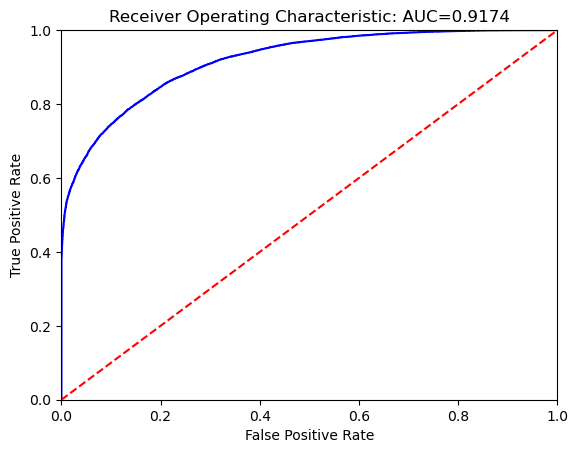

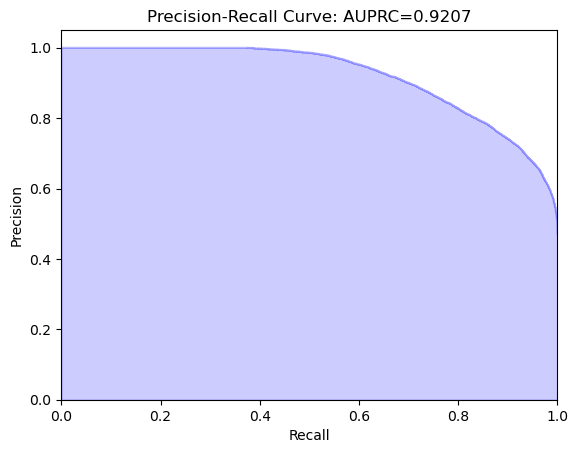

Epoch 1/20
1882/1882 [==============================] - 6s 2ms/step - loss: 0.4505 - accuracy: 0.8002 - auc: 0.8816 - auprc: 0.8760 - true_positives: 134098.0000 - true_negatives: 167004.0000 - precision: 0.8110 - recall: 0.7532
Epoch 2/20
1882/1882 [==============================] - 5s 3ms/step - loss: 0.3781 - accuracy: 0.8177 - auc: 0.9060 - auprc: 0.9104 - true_positives: 136514.0000 - true_negatives: 171182.0000 - precision: 0.8345 - recall: 0.7668
Epoch 3/20
1882/1882 [==============================] - 5s 3ms/step - loss: 0.3721 - accuracy: 0.8198 - auc: 0.9086 - auprc: 0.9128 - true_positives: 136875.0000 - true_negatives: 171598.0000 - precision: 0.8370 - recall: 0.7688
Epoch 4/20
1882/1882 [==============================] - 5s 3ms/step - loss: 0.3696 - accuracy: 0.8212 - auc: 0.9095 - auprc: 0.9138 - true_positives: 137259.0000 - true_negatives: 171765.0000 - precision: 0.8383 - recall: 0.7709
Epoch 5/20
1882/1882 [==============================] - 7s 4ms/step - loss: 0.3662 -

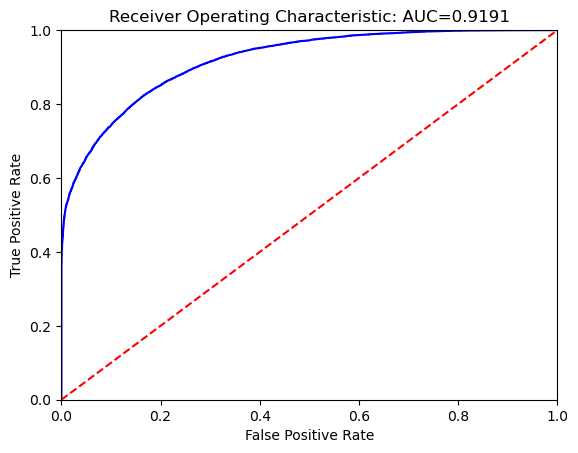

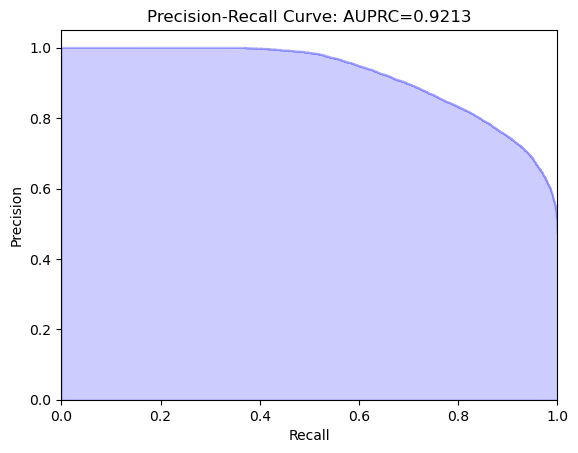

Epoch 1/20
1882/1882 [==============================] - 6s 3ms/step - loss: 0.4208 - accuracy: 0.8025 - auc: 0.8865 - auprc: 0.8853 - true_positives: 134926.0000 - true_negatives: 167063.0000 - precision: 0.8123 - recall: 0.7578
Epoch 2/20
1882/1882 [==============================] - 5s 3ms/step - loss: 0.3765 - accuracy: 0.8185 - auc: 0.9068 - auprc: 0.9109 - true_positives: 137276.0000 - true_negatives: 170716.0000 - precision: 0.8329 - recall: 0.7710
Epoch 3/20
1882/1882 [==============================] - 5s 3ms/step - loss: 0.3713 - accuracy: 0.8208 - auc: 0.9090 - auprc: 0.9131 - true_positives: 137934.0000 - true_negatives: 170940.0000 - precision: 0.8347 - recall: 0.7747
Epoch 4/20
1882/1882 [==============================] - 5s 2ms/step - loss: 0.3670 - accuracy: 0.8217 - auc: 0.9107 - auprc: 0.9146 - true_positives: 138210.0000 - true_negatives: 171000.0000 - precision: 0.8353 - recall: 0.7763
Epoch 5/20
1882/1882 [==============================] - 5s 3ms/step - loss: 0.3633 -

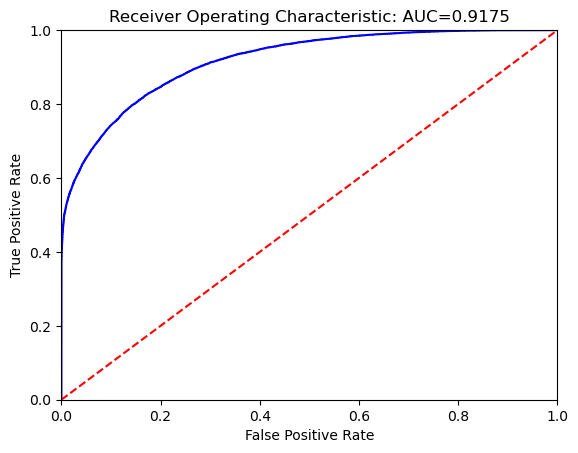

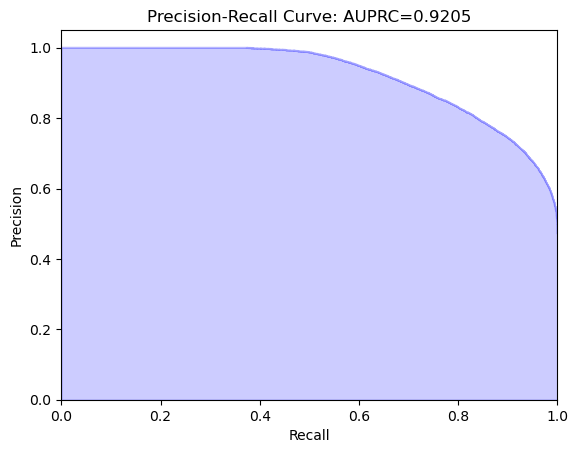

Epoch 1/20
1882/1882 [==============================] - 6s 3ms/step - loss: 0.4268 - accuracy: 0.8010 - auc: 0.8848 - auprc: 0.8814 - true_positives: 134655.0000 - true_negatives: 166762.0000 - precision: 0.8105 - recall: 0.7563
Epoch 2/20
1882/1882 [==============================] - 5s 3ms/step - loss: 0.3748 - accuracy: 0.8197 - auc: 0.9079 - auprc: 0.9113 - true_positives: 137444.0000 - true_negatives: 171006.0000 - precision: 0.8346 - recall: 0.7720
Epoch 3/20
1882/1882 [==============================] - 5s 2ms/step - loss: 0.3699 - accuracy: 0.8210 - auc: 0.9098 - auprc: 0.9135 - true_positives: 137967.0000 - true_negatives: 170969.0000 - precision: 0.8349 - recall: 0.7749
Epoch 4/20
1882/1882 [==============================] - 5s 2ms/step - loss: 0.3663 - accuracy: 0.8217 - auc: 0.9112 - auprc: 0.9150 - true_positives: 137958.0000 - true_negatives: 171237.0000 - precision: 0.8363 - recall: 0.7749
Epoch 5/20
1882/1882 [==============================] - 5s 3ms/step - loss: 0.3621 -

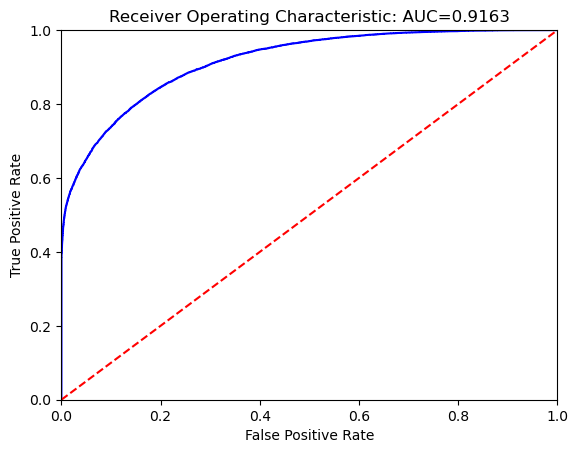

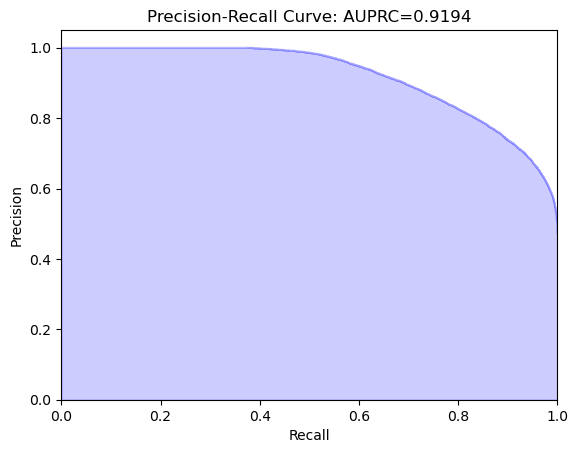

Epoch 1/20
1882/1882 [==============================] - 6s 2ms/step - loss: 0.4273 - accuracy: 0.8008 - auc: 0.8843 - auprc: 0.8824 - true_positives: 134579.0000 - true_negatives: 166737.0000 - precision: 0.8103 - recall: 0.7559
Epoch 2/20
1882/1882 [==============================] - 5s 2ms/step - loss: 0.3833 - accuracy: 0.8153 - auc: 0.9036 - auprc: 0.9080 - true_positives: 136547.0000 - true_negatives: 170232.0000 - precision: 0.8298 - recall: 0.7669
Epoch 3/20
1882/1882 [==============================] - 5s 3ms/step - loss: 0.3775 - accuracy: 0.8175 - auc: 0.9061 - auprc: 0.9105 - true_positives: 136734.0000 - true_negatives: 170884.0000 - precision: 0.8332 - recall: 0.7680
Epoch 4/20
1882/1882 [==============================] - 5s 2ms/step - loss: 0.3719 - accuracy: 0.8193 - auc: 0.9083 - auprc: 0.9126 - true_positives: 137132.0000 - true_negatives: 171166.0000 - precision: 0.8351 - recall: 0.7702
Epoch 5/20
1882/1882 [==============================] - 5s 2ms/step - loss: 0.3676 -

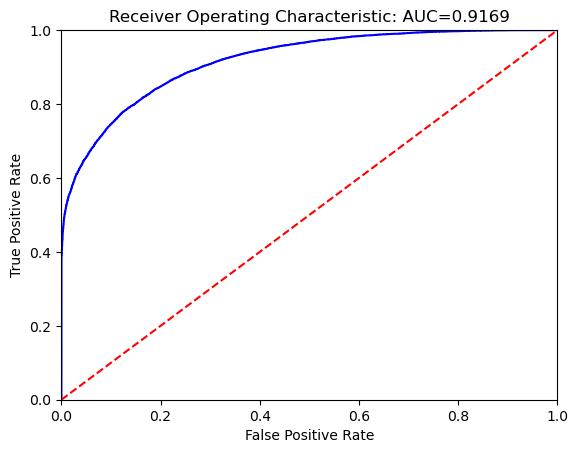

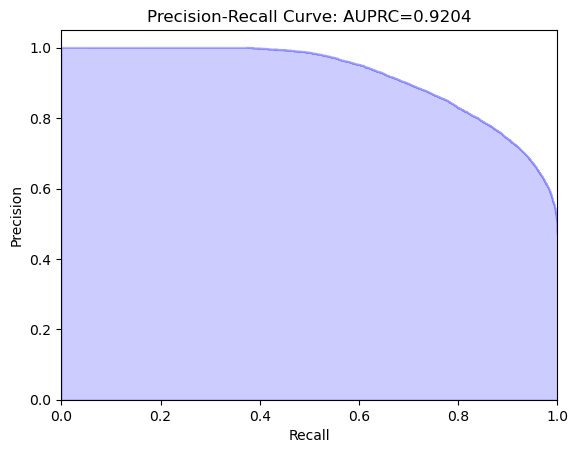

Epoch 1/20
1882/1882 [==============================] - 6s 3ms/step - loss: 0.4188 - accuracy: 0.8026 - auc: 0.8872 - auprc: 0.8861 - true_positives: 135254.0000 - true_negatives: 166763.0000 - precision: 0.8112 - recall: 0.7597
Epoch 2/20
1882/1882 [==============================] - 5s 3ms/step - loss: 0.3794 - accuracy: 0.8170 - auc: 0.9054 - auprc: 0.9093 - true_positives: 136973.0000 - true_negatives: 170474.0000 - precision: 0.8314 - recall: 0.7693
Epoch 3/20
1882/1882 [==============================] - 5s 2ms/step - loss: 0.3734 - accuracy: 0.8193 - auc: 0.9079 - auprc: 0.9119 - true_positives: 137381.0000 - true_negatives: 170897.0000 - precision: 0.8340 - recall: 0.7716
Epoch 4/20
1882/1882 [==============================] - 5s 3ms/step - loss: 0.3705 - accuracy: 0.8200 - auc: 0.9093 - auprc: 0.9133 - true_positives: 137551.0000 - true_negatives: 171023.0000 - precision: 0.8348 - recall: 0.7726
Epoch 5/20
1882/1882 [==============================] - 8s 4ms/step - loss: 0.3672 -

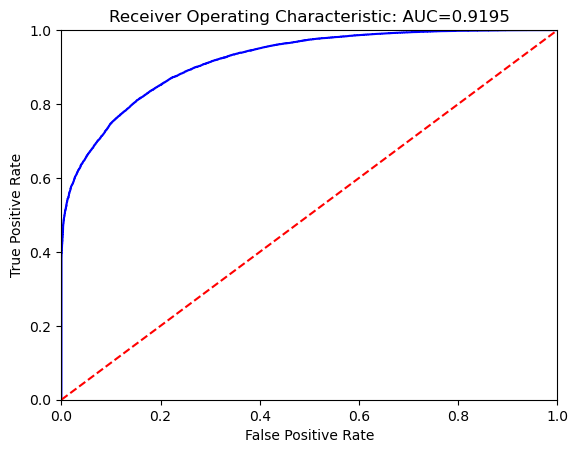

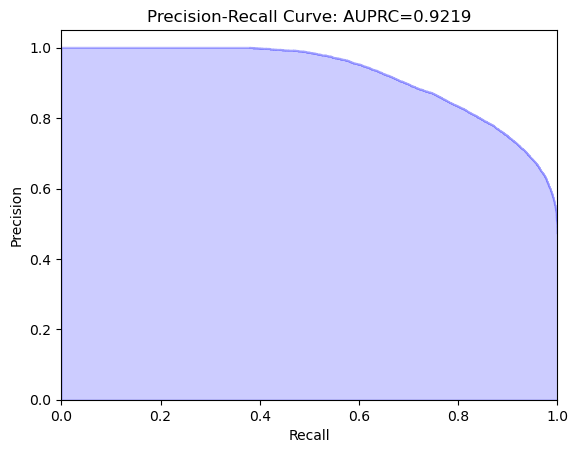

Epoch 1/20
1882/1882 [==============================] - 11s 4ms/step - loss: 0.4194 - accuracy: 0.8038 - auc: 0.8879 - auprc: 0.8856 - true_positives: 134356.0000 - true_negatives: 168104.0000 - precision: 0.8167 - recall: 0.7546
Epoch 2/20
1882/1882 [==============================] - 6s 3ms/step - loss: 0.3800 - accuracy: 0.8167 - auc: 0.9052 - auprc: 0.9095 - true_positives: 136225.0000 - true_negatives: 171092.0000 - precision: 0.8338 - recall: 0.7651
Epoch 3/20
1882/1882 [==============================] - 5s 3ms/step - loss: 0.3734 - accuracy: 0.8196 - auc: 0.9080 - auprc: 0.9122 - true_positives: 137391.0000 - true_negatives: 171033.0000 - precision: 0.8347 - recall: 0.7717
Epoch 4/20
1882/1882 [==============================] - 5s 2ms/step - loss: 0.3684 - accuracy: 0.8214 - auc: 0.9102 - auprc: 0.9141 - true_positives: 138100.0000 - true_negatives: 170979.0000 - precision: 0.8351 - recall: 0.7757
Epoch 5/20
1882/1882 [==============================] - 6s 3ms/step - loss: 0.3671 

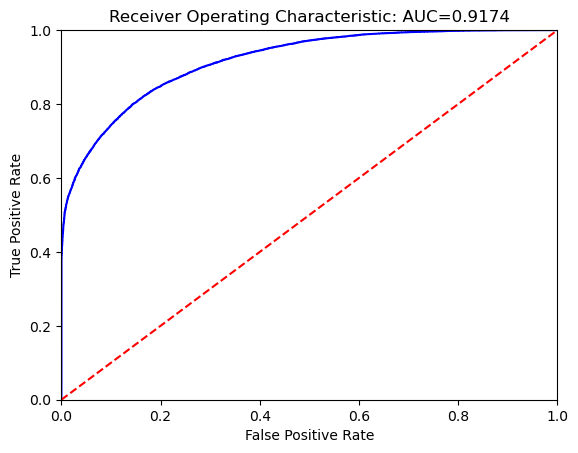

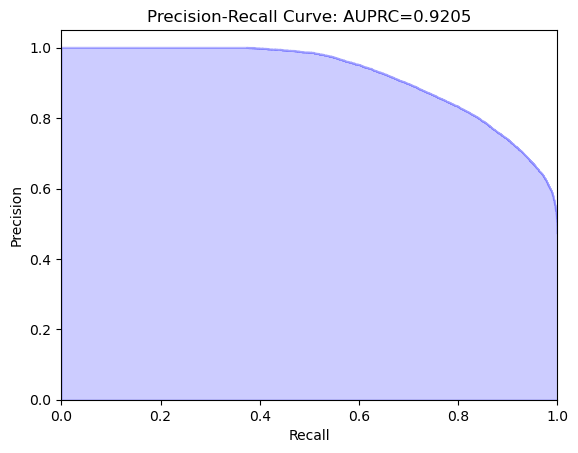

In [274]:
from tensorflow.keras.optimizers import Adam
mlp_results = perform_10_fold_cv_mlp(X_train, y_train, random_seed=random_seed)

## Score Performance
We check the performance of the Scores we Calculated.
Analyze and compare the performance of different scores (e.g., MEWS Score, NEWS Score) in predicting the target variable y_test using ROC curve analysis

In [ ]:
def get_score_performance(s, random_seed=0):
    print(s)
    score = np.array(df_test[s])
    result = PlotROCCurve(score,y_test, ci=confidence_interval, random_seed=random_seed)
    runtime = 0
    results = [s]
    results.extend(result)
    results.append(runtime)
    result_hospitalization_outcome.append(results)

esi
AUC: 0.8103367890359986
AUPRC: 0.19983705888806375
Sensitivity: 0.8831908831908832
Specificity: 0.6393159352527127
Score thresold: -2.0
2.5 97.5


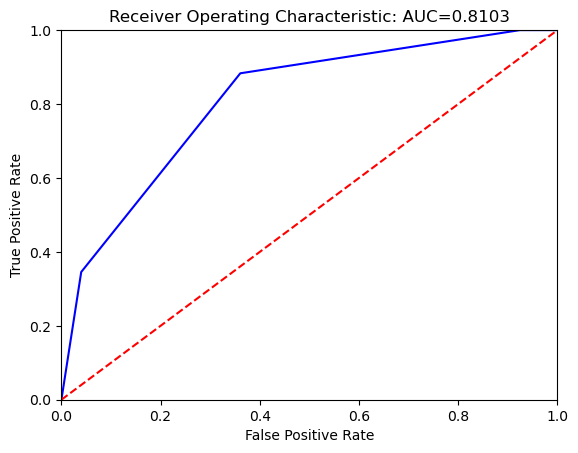

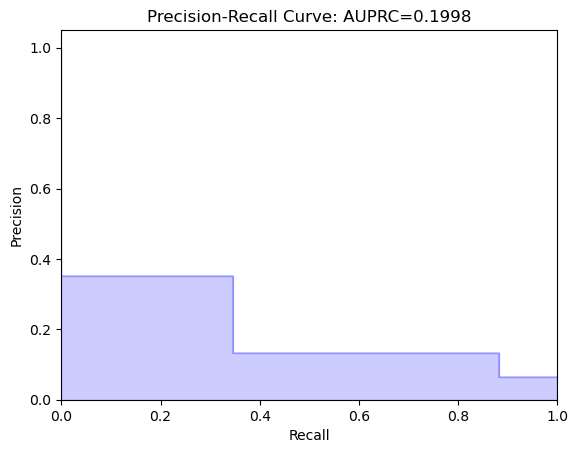

NameError: name 'result_hospitalization_outcome' is not defined

In [ ]:
df_test["esi"] = -df_test["triage_acuity"]
get_score_performance("esi", random_seed=random_seed)

## Extracting Rules

In [ ]:
#Make numpy arrays
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [ ]:
#pip install Te2Rules

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics


import te2rules
from te2rules.explainer import ModelExplainer

print("Using te2rules version: " + str(te2rules.__version__))

Using te2rules version: 0.7.0


In [ ]:
#Train an XGboost Model

model = GradientBoostingClassifier(random_state=random_seed)
model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=0)

In [ ]:
#probabilities associated with the positive class (class 1)
y_train_pred = model.predict(X_train)
y_train_pred_score = model.predict_proba(X_train)[:, 1]

y_test_pred = model.predict(X_test)
y_test_pred_score = model.predict_proba(X_test)[:, 1]

In [ ]:
accuracy = model.score(X_test, y_test)
print("Accuracy")
print(accuracy)

Accuracy
0.8385194929442717


In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred_score)
auc = metrics.auc(fpr, tpr)
print("AUC")
print(auc)

AUC
0.9215801515411395


In [ ]:
#X_train

In [ ]:
#Explain the Model using Te2Rules

model_explainer = ModelExplainer(
    model=model,
    feature_names=variable
)

rules = model_explainer.explain(
    X=X_train, y=y_train_pred,
    #num_stages = 10,
    min_precision = 0.95
)

100%|██████████| 1175/1175 [01:53<00:00, 10.35it/s]


KeyboardInterrupt: ignored

In [ ]:
learned_rules = rules.solution_rules


NameError: ignored

In [ ]:
from te2rules.explainer import ModelExplainer

# Initialize ModelExplainer
model_explainer = ModelExplainer(
    model=model,
    feature_names=variable
)

try:
    # Attempt to extract rules
    rules = model_explainer.explain(
        X=X_train, y=y_train_pred,
        #num_stages=10,
        min_precision=0.95
    )

    # Save rules to a file or data structure
    with open('extracted_rules.txt', 'w') as rule_file:
        for rule in rules:
            rule_file.write(str(rule) + '\n')

except KeyboardInterrupt:
    # Handle the interrupt signal (e.g., Ctrl+C)
    print("Rule extraction interrupted. Saving available rules...")

    # Save the available rules to a file or data structure
    with open('partial_extracted_rules.txt', 'w') as rule_file:
        for rule in rules:
            rule_file.write(str(rule) + '\n')


100%|████████████████████████████████████████████████████████████████████████| 350093/350093 [3:11:31<00:00, 30.46it/s]


Rule extraction interrupted. Saving available rules...


In [ ]:
from te2rules.explainer import ModelExplainer

# Initialize ModelExplainer
model_explainer = ModelExplainer(
    model=model,
    feature_names=variable
)

# Specify the file where previously extracted rules are stored
previous_rules_file = 'partial_extracted_rules.txt'

try:
    # Attempt to load previously extracted rules
    with open(previous_rules_file, 'r') as rule_file:
        previous_rules = [line.strip() for line in rule_file]

    # Continue the rule extraction process from where it left off
    rules = model_explainer.explain(
        X=X_train, y=y_train_pred,
        #num_stages=10,
        min_precision=0.95,
        previous_rules=previous_rules  # Pass the loaded rules as a starting point
    )

    # Save the updated rules to the same file
    with open(previous_rules_file, 'w') as rule_file:
        for rule in rules:
            rule_file.write(str(rule) + '\n')

except FileNotFoundError:
    # Handle the case where no previous rules file exists
    print(f"No previous rules file '{previous_rules_file}' found. Starting from scratch...")

except KeyboardInterrupt:
    # Handle the interrupt signal (e.g., Ctrl+C)
    print("Rule extraction interrupted. Saving available rules...")

    # Ensure that the 'rules' variable is defined before saving
    if 'rules' in locals():
        # Save the available rules to a file or data structure
        with open(previous_rules_file, 'w') as rule_file:
            for rule in rules:
                rule_file.write(str(rule) + '\n')

No previous rules file 'partial_extracted_rules.txt' found. Starting from scratch...


In [ ]:
print(str(len(rules)) + "rules found")

NameError: name 'rules' is not defined

## Results Output

In [ ]:
result_df = pd.DataFrame(result_hospitalization_outcome, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
result_df.to_csv(os.path.join(path, 'result_hospitalization_outcome.csv'), index=False)
result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
formatted_result_df.to_csv(os.path.join(path, 'task1_19.csv'), index=False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,RF,0.450,0.927 (0.925-0.928),0.929 (0.928-0.931),0.836 (0.829-0.839),0.85 (0.848-0.86),154.887
1,GB,0.419,0.922 (0.92-0.923),0.926 (0.924-0.928),0.827 (0.817-0.832),0.846 (0.844-0.855),203.356
2,LR,0.408,0.91 (0.909-0.912),0.916 (0.914-0.917),0.807 (0.799-0.818),0.84 (0.828-0.847),10.241


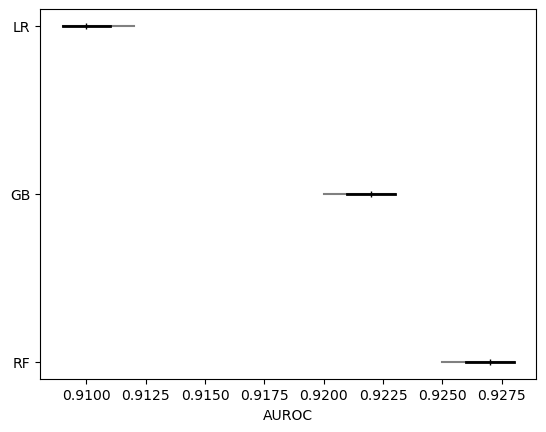

In [ ]:
#Plotting

from helpers import plot_confidence_interval
plot_confidence_interval(result_df, metric='auroc', ci=confidence_interval, name = "AUROC",
                         my_file = 'AUROC_hospitalization.eps', my_path = output_path)

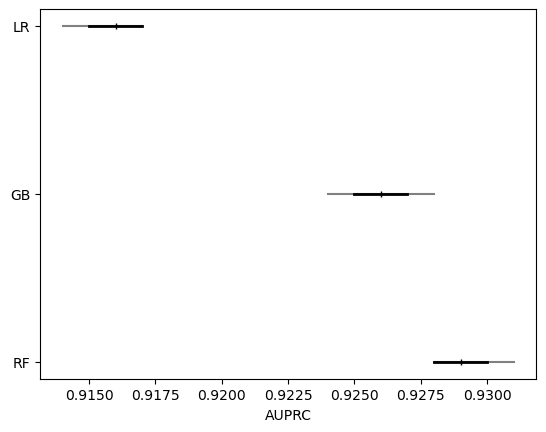

In [ ]:
plot_confidence_interval(result_df, metric='ap', ci=confidence_interval, name = "AUPRC",
                         my_file = 'AUROC_hospitalization.eps', my_path = output_path)

# Task 2 Modeling for predicting critical outcome at ED triage

Work Flow:
1. Task-specific filter
2. Variable selection
3. Modeling script
4. Performance output


In [ ]:
# critical_outcome: If Either outcome_icu_transfer_12h or Inhospital_mortality var is True we have a critical outcome.

In [479]:
#set the random seed
random.seed(random_seed)
np.random.seed(random_seed)

In [ ]:
#variable

In [525]:
#top 15 most important var's

variable = ["microbio_event", "triage_acuity", "triage_sbp_knn", "triage_heartrate_knn",
            'age','triage_dbp_knn',"triage_temperature_knn", "triage_resprate_knn",
            'triage_o2sat_knn','triage_pain_knn','n_ed_365d',"med_event",'n_hosp_365d',
            'gender','n_icu_365d']
            
    
outcome = "outcome_critical"

In [404]:
variable = ["age", "gender", "microbio_event","med_event",
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            "triage_temperature_knn", "triage_heartrate_knn", "triage_resprate_knn", 
            "triage_o2sat_knn", "triage_sbp_knn", "triage_dbp_knn", "triage_pain_knn", "triage_acuity",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache",
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope", 
            "chiefcom_dizziness", 
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", 
            "cci_Pulmonary", "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", 
            "cci_DM2", "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", 
            "cci_Cancer2", "cci_HIV", 
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2", 
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss",
            "eci_Anemia", "eci_Alcohol", "eci_Drugs","eci_Psychoses", "eci_Depression"]

outcome = "outcome_critical"

In [ ]:
# Replace missing values with -1 in the specified columns
columns_to_replace = ['time_to_med_event_hr', 'time_to_microbioevent_hr']
df_train[columns_to_replace] = df_train[columns_to_replace].fillna(-1)
df_test[columns_to_replace] = df_test[columns_to_replace].fillna(-1)

In [406]:
dtypes = {
    # ... Other columns
    #"Therapeutic_Other Medication": "int64",
    #"Therapeutic_Analgesic": "int64",
    #"Therapeutic_Antacid": "int64",
    #"Therapeutic_Antiemetic": "int64",
    #"Therapeutic_Antibiotic": "int64", "Therapeutic_Vaccine": "int64",
    #"Therapeutic_Electrolyte": "int64", "Therapeutic_Diuretic": "int64",
    #"Therapeutic_Bronchodilator": "int64","Therapeutic_Corticosteroid":"int64",
    #"Therapeutic_Anticonvulsant": "int64", "Therapeutic_Anticoagulant": "int64",
    #"Therapeutic_Local Anesthetic": "int64", "Therapeutic_Anxiolytic": "int64",
    #"Therapeutic_Anti-inflammatory": "int64","Therapeutic_Vitamin Supplement": "int64",
    #"Therapeutic_Anesthetic": "int64", "Therapeutic_Vitamin": "int64",
    #"Therapeutic_Antipsychotic": "int64", "Therapeutic_Beta Blocker": "int64",
    #"Therapeutic_Antihistamine": "int64",

    "microbio_event": "bool",
    "med_event": "bool",

    #"time_to_med_event_hr": "float64",
    #"time_to_microbioevent_hr": "float64",
    # ... Other columns
}
# Apply the data types to the DataFrame
df_train = df_train.astype(dtypes)
df_test = df_test.astype(dtypes)

In [527]:
X_train = df_master[variable].copy()
y_train = df_master[outcome].copy()
#X_test = df_test[variable].copy()
#y_test = df_test[outcome].copy()

In [529]:
#set dtypes
X_train.dtypes.to_frame().T

,microbio_event,triage_acuity,triage_sbp_knn,triage_heartrate_knn,age,triage_dbp_knn,triage_temperature_knn,triage_resprate_knn,triage_o2sat_knn,triage_pain_knn,n_ed_365d,med_event,n_hosp_365d,gender,n_icu_365d
0,bool,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,bool,int64,object,int64


In [531]:
y_train

0         False
1         False
2         False
3         False
4         False
          ...  
418095    False
418096    False
418097    False
418098    False
418099    False
Name: outcome_critical, Length: 418100, dtype: bool

In [533]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
#X_test['gender'] = encoder.transform(X_test['gender'])
#X_train

In [511]:
#10 folds cv
print('class ratio')
ratio = y_train.sum()/(~y_train).sum()
print('positive : negative =', ratio, ': 1')

class ratio
positive : negative = 0.06332384709092805 : 1


In [ ]:
print('class ratio')
ratio = y_train.sum()/(~y_train).sum()
print('positive : negative =', ratio, ': 1')

class ratio
positive : negative = 0.06354632029126059 : 1


In [513]:
# Container for all results
result_critical_outcome = []

## Random Forest

### Single run

Training time: 106.21376276016235 seconds
AUC: 0.9263157115798593
AUPRC: 0.5350488178518196
Sensitivity: 0.8573463573463573
Specificity: 0.8547632963179428
Score thresold: 0.09
2.5 97.5


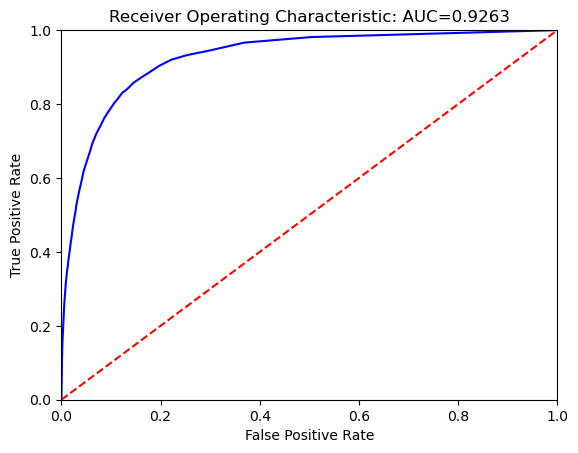

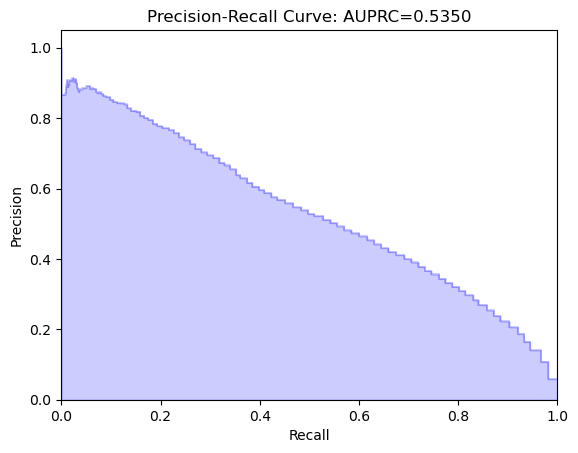

[0.07427314 0.01184374 0.13171895 0.01476644 0.00524367 0.0082405
 0.0151802  0.00521784 0.00824795 0.01449797 0.00295979 0.00565647
 0.01003396 0.06618529 0.07552236 0.05205756 0.04879064 0.08238414
 0.06980212 0.03965595 0.08898935 0.00459635 0.00596696 0.00342277
 0.00117923 0.00201456 0.00218335 0.0024583  0.00484149 0.00248021
 0.00246818 0.00421623 0.00504081 0.0041831  0.00427404 0.00236456
 0.00587662 0.00230732 0.00230363 0.00392567 0.00603065 0.00391303
 0.00201639 0.00443109 0.00473585 0.00231824 0.00335121 0.00087409
 0.00591425 0.00394772 0.00377639 0.00424269 0.00717683 0.00483597
 0.00453151 0.00151908 0.00462333 0.00455644 0.00381764 0.00589811
 0.00189607 0.00377913 0.00388607 0.00287485 0.00200454 0.0056774 ]


NameError: name 'result_critical_outcome' is not defined

In [420]:
rf= RandomForestClassifier(random_state=random_seed)
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
importances = rf.feature_importances_
print(importances)

results = ["RF"]
results.extend(result)
results.append(runtime)
result_critical_outcome.append(results)

In [568]:
importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
#importance_df.to_csv(os.path.join(path, 'importances_outcome_critical_830.csv'))
importance_df = importance_df.sort_values(by='Importance', axis=0,ascending=False).reset_index()

In [570]:
importance_df

,index,Variable,Importance
0,2,triage_sbp_knn,0.131719
1,14,n_icu_365d,0.075522
2,0,microbio_event,0.074273
3,13,gender,0.066185
4,6,triage_temperature_knn,0.015180
5,3,triage_heartrate_knn,0.014766
6,9,triage_pain_knn,0.014498
7,1,triage_acuity,0.011844
8,12,n_hosp_365d,0.010034
9,8,triage_o2sat_knn,0.008248


In [426]:
#visualize importances to reduce variables, only include ones with highest importance
accuracy = rf.score(X_test, y_test)
print("Accuracy")
print(accuracy)

Accuracy
0.9511121741210237


In [521]:
#importance_df

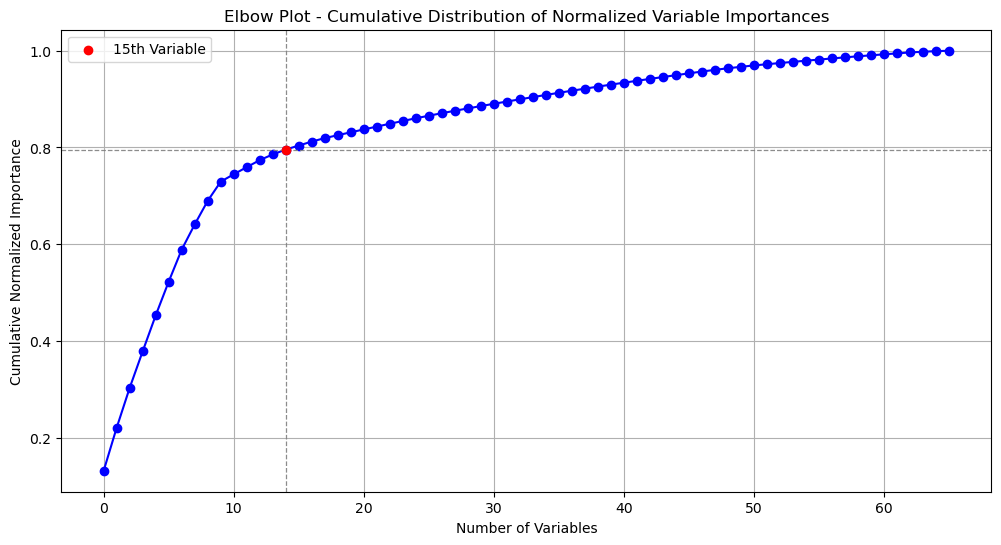

In [472]:
# Normalize the importances
importance_df['Normalized_Importance'] = importance_df['Importance'] / importance_df['Importance'].sum()

# Calculate cumulative sum of normalized importances
importance_df['Cumulative_Normalized_Importance'] = importance_df['Normalized_Importance'].cumsum()

# Plot the elbow plot
plt.figure(figsize=(12, 6))
plt.plot(importance_df.index, importance_df['Cumulative_Normalized_Importance'], marker='o', linestyle='-', color='b')
plt.title('Elbow Plot - Cumulative Distribution of Normalized Variable Importances')
plt.xlabel('Number of Variables')
plt.ylabel('Cumulative Normalized Importance')
plt.grid(True)

#Mark the 14th variable point
variable_14_x = 14  # index is 0-based
variable_14_y = importance_df['Cumulative_Normalized_Importance'].iloc[14]

# Add dotted lines
plt.axvline(x=variable_14_x, color='gray', linestyle='--', linewidth=0.9, alpha=0.9)
plt.axhline(y=variable_14_y, color='gray', linestyle='--', linewidth=0.9, alpha=0.9)

# Create a marker at the 14th variable point
plt.scatter(variable_14_x, variable_14_y, color='red', zorder=5,label='15th Variable')  #line
# Add legend
plt.legend()
plt.show()

### 10 folds CV all vars

In [373]:
# Initialize Random Forest Classifier
rf = RandomForestClassifier(random_state=random_seed)

In [375]:
#Perform 10-fold cross-validation with multiple scoring metrics for all vars
print("RandomForest:")
start = time.time()
y_probas = cross_val_predict(rf, X_train, y_train, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=random_seed), method='predict_proba')
runtime = time.time() - start
print('Training time:', runtime, 'seconds')

RandomForest:
Training time: 1175.737396478653 seconds


AUC: 0.9256611374207484
AUPRC: 0.5341554118877461
Sensitivity: 0.8728061367926423
Specificity: 0.8395578851528862
Score thresold: 0.07092857142857141
2.5 97.5


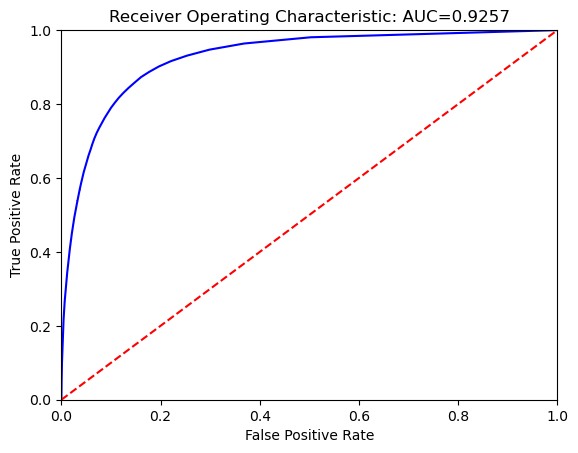

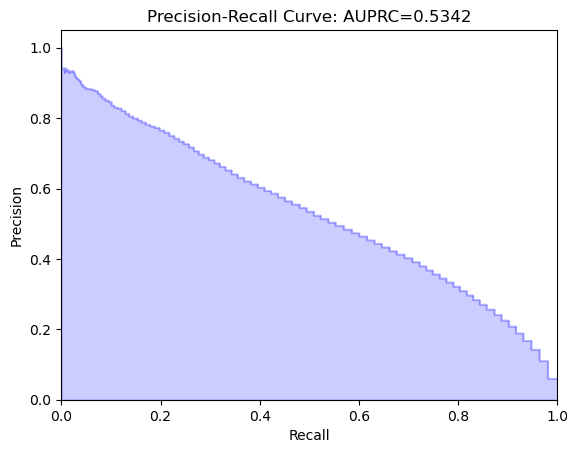

[0.9256611374207484,
 0.5341554118877461,
 0.8728061367926423,
 0.8395578851528862,
 0.07092857142857141,
 0.9241498880254373,
 0.9274976610509594,
 0.0009785160556197042,
 0.5277110966306564,
 0.5402423057179536,
 0.0036833851123772555,
 0.8555289171567794,
 0.8746668191447271,
 0.007060094961116107,
 0.8389505588084621,
 0.8540503267850045,
 0.006766886017794936]

In [376]:
PlotROCCurveNew(y_probas[:, 1],y_train) 

### Top 15 var's 10 folds CV

In [515]:
# Initialize Random Forest Classifier
rf = RandomForestClassifier(random_state=random_seed)

In [517]:
#Perform 10-fold cross-validation with multiple scoring metrics for all vars
print("RandomForest:")
start = time.time()
y_probas = cross_val_predict(rf, X_train, y_train, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=random_seed), method='predict_proba')
runtime = time.time() - start
print('Training time:', runtime, 'seconds')

RandomForest:
Training time: 846.6319210529327 seconds


AUC: 0.9208260355919851
AUPRC: 0.5261966584048476
Sensitivity: 0.8569420458652958
Specificity: 0.8475461659558343
Score thresold: 0.075
2.5 97.5


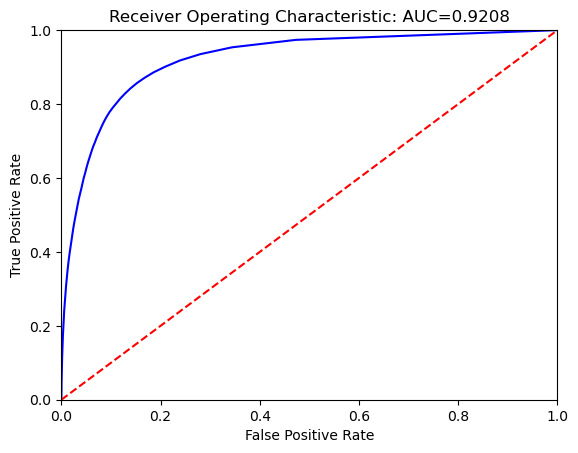

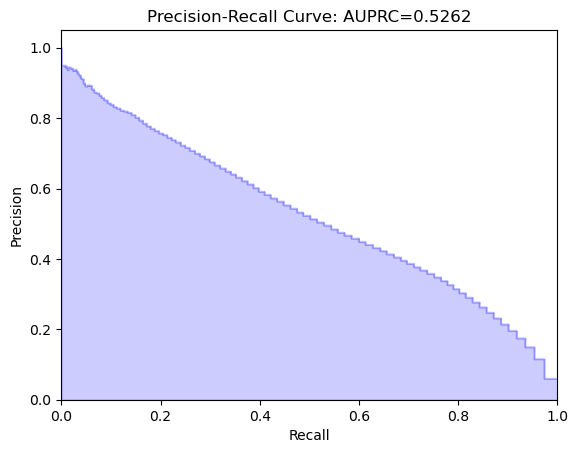

[0.9208260355919851,
 0.5261966584048476,
 0.8569420458652958,
 0.8475461659558343,
 0.075,
 0.9187192392467198,
 0.9226862682031289,
 0.0010834823218923652,
 0.5187715017377905,
 0.5323169295068559,
 0.0038077023523184475,
 0.8517038924412811,
 0.8605139467961235,
 0.0023459602456139808,
 0.846589571994214,
 0.8488998960517259,
 0.0006234230845009834]

In [518]:
PlotROCCurveNew(y_probas[:, 1],y_train) 

## Gradient Boosting

GradientBoosting:
Training time: 207.17791533470154 seconds
AUC: 0.9393788520983398
AUPRC: 0.6479671602398764
Sensitivity: 0.8632478632478633
Specificity: 0.8655629812212537
Score thresold: 0.06181234119938378
2.5 97.5


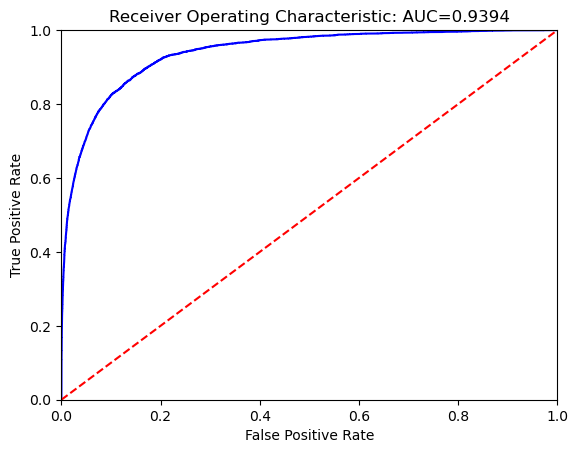

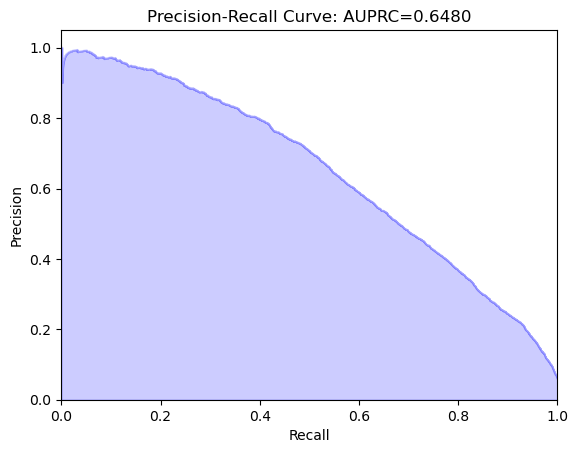

In [ ]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=random_seed)
start = time.time()
gb.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_critical_outcome.append(results)

### 10 folds CV, top 15 vars

In [535]:
## Initialize gb Classifier
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=random_seed)

In [537]:
# Top 13 new Perform 10-fold cross-validation with multiple scoring metrics
print("Gradeint Boosting:")
start = time.time()
y_probas = cross_val_predict(gb, X_train, y_train, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=random_seed), method='predict_proba')
runtime = time.time() - start
print('Training time:', runtime, 'seconds')


Gradeint Boosting:
Training time: 712.8940587043762 seconds


AUC: 0.929935502812432
AUPRC: 0.5404879824275456
Sensitivity: 0.8624442748704767
Specificity: 0.8474444368147589
Score thresold: 0.05430977527947167
2.5 97.5


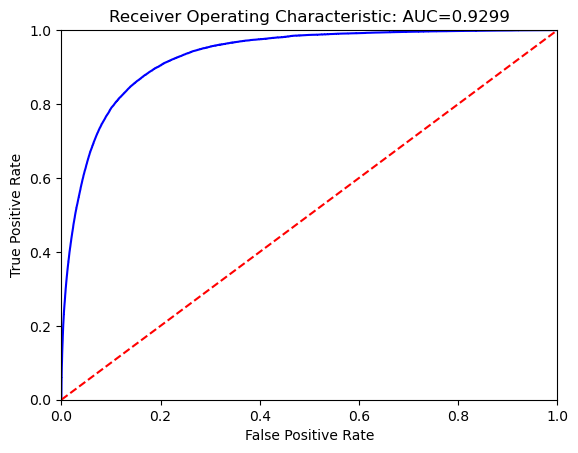

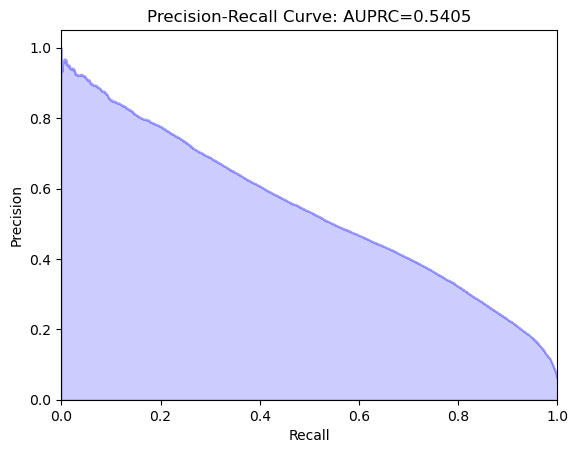

[0.929935502812432,
 0.5404879824275456,
 0.8624442748704767,
 0.8474444368147589,
 0.05430977527947167,
 0.9287715064805916,
 0.9314230872954871,
 0.0008052387118837429,
 0.5356999282316897,
 0.5474648600279973,
 0.0033388829873618408,
 0.8508595393554744,
 0.8672778126978592,
 0.00449901381299841,
 0.8450866513383126,
 0.8567335204904796,
 0.003657221496757366]

In [538]:
PlotROCCurveNew(y_probas[:, 1],y_train) 

## Logistic Regression

Logistic Regression:


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 9.517468690872192 seconds
AUC: 0.8930758824350165
AUPRC: 0.47459716001706936
Sensitivity: 0.8064713064713065
Specificity: 0.8396691484766091
Score thresold: 0.06502556471981051
2.5 97.5


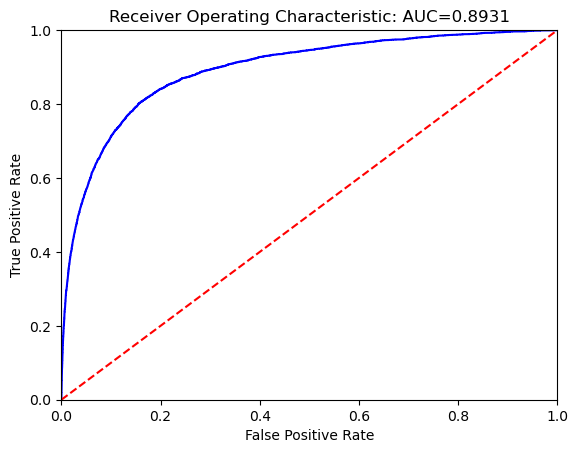

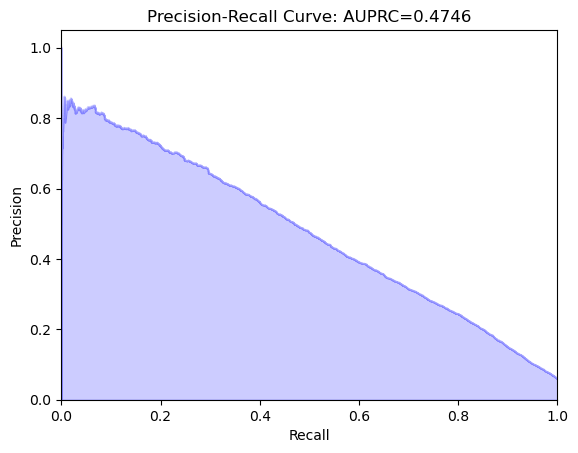

In [ ]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(random_state=random_seed)
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
import pickle
with open('task2_logreg.pickle', 'wb') as model_dump:
    pickle.dump(logreg, model_dump)
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1], y_test, ci=confidence_interval, random_seed=random_seed)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_critical_outcome.append(results)

## Deep Learning

In [ ]:
class MLP(tf.keras.Model):
    def __init__(self):
        super(MLP, self).__init__()
        self.dense_1 = Dense(128, activation='relu')
        self.dense_2 = Dense(64, activation='relu')
        self.classifier = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.classifier(x)

In [ ]:
# skip this cell if not retraining
mlp = MLP()
mlp.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')},
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train.astype(np.float32), y_train, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
mlp.save('critical_triage_mlp')

Epoch 1/20
1673/1673 [==============================] - 9s 4ms/step - loss: 0.2301 - accuracy: 0.9428 - auc: 0.8674 - auprc: 0.3890 - true_positives: 6297.0000 - true_negatives: 309062.0000 - precision: 0.5368 - recall: 0.3151
Epoch 2/20
1673/1673 [==============================] - 6s 4ms/step - loss: 0.1453 - accuracy: 0.9488 - auc: 0.9036 - auprc: 0.5110 - true_positives: 7191.0000 - true_negatives: 310155.0000 - precision: 0.6236 - recall: 0.3598
Epoch 3/20
1673/1673 [==============================] - 7s 4ms/step - loss: 0.1368 - accuracy: 0.9510 - auc: 0.9147 - auprc: 0.5441 - true_positives: 7318.0000 - true_negatives: 310763.0000 - precision: 0.6623 - recall: 0.3662
Epoch 4/20
1673/1673 [==============================] - 7s 4ms/step - loss: 0.1320 - accuracy: 0.9522 - auc: 0.9217 - auprc: 0.5672 - true_positives: 7401.0000 - true_negatives: 311080.0000 - precision: 0.6843 - recall: 0.3703
Epoch 5/20
1673/1673 [==============================] - 7s 4ms/step - loss: 0.1286 - accurac

INFO:tensorflow:Assets written to: critical_triage_mlp\assets


MLP:
2614/2614 [==============================] - 8s 3ms/step
AUC: 0.9381223186238054
AUPRC: 0.6408055787679936
Sensitivity: 0.8756613756613757
Specificity: 0.8611160521434198
Score thresold: 0.064344674
2.5 97.5


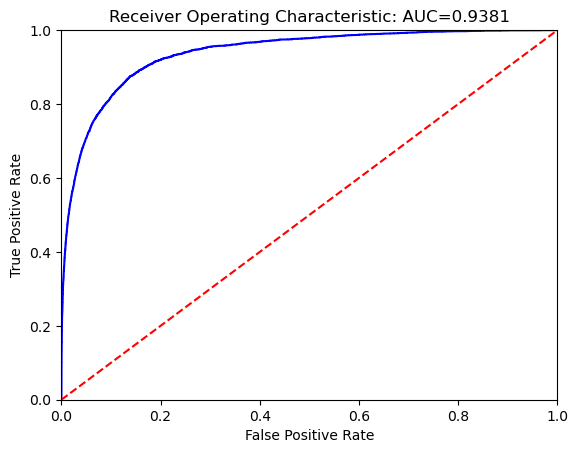

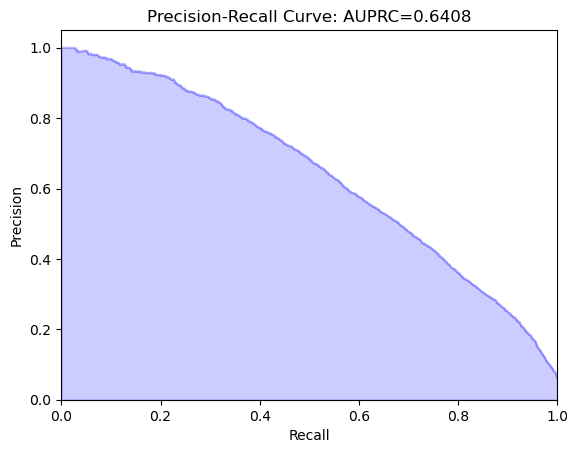

In [ ]:
print("MLP:")
mlp = load_model('critical_triage_mlp')
probs = mlp.predict(X_test.astype(np.float32))
result = PlotROCCurve(probs,y_test, ci=confidence_interval, random_seed=random_seed)
results = ["MLP"]
results.extend(result)
results.append(runtime)
result_critical_outcome.append(results)

## Results Output

In [ ]:
result_df = pd.DataFrame(result_critical_outcome, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
result_df.to_csv(os.path.join(path, 'result_critical_outcome.csv'), index=False)
result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
formatted_result_df.to_csv(os.path.join(path, 'task2_19.csv'), index=False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,RF,0.090,0.939 (0.937-0.944),0.655 (0.649-0.667),0.87 (0.865-0.882),0.873 (0.861-0.88),160.140
1,GB,0.062,0.939 (0.937-0.943),0.648 (0.641-0.66),0.863 (0.857-0.882),0.866 (0.85-0.874),207.178
2,LR,0.065,0.893 (0.89-0.897),0.475 (0.466-0.487),0.806 (0.808-0.83),0.84 (0.821-0.842),9.517


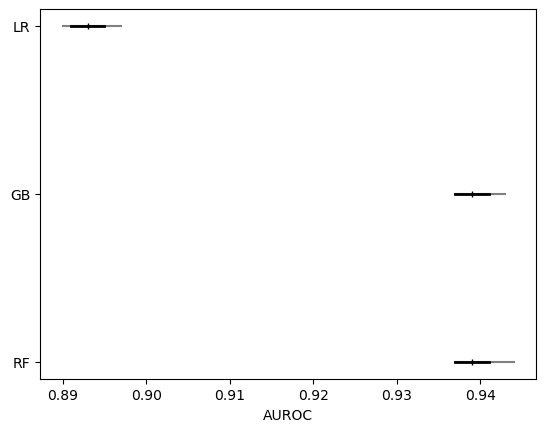

In [ ]:
#Plotting

from helpers import plot_confidence_interval
plot_confidence_interval(result_df, metric='auroc', ci=confidence_interval, name = "AUROC",
                         my_file = 'AUROC_critical.eps', my_path = output_path)

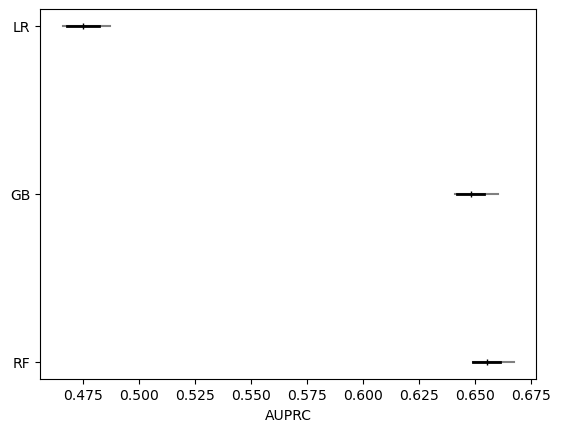

In [ ]:
plot_confidence_interval(result_df, metric='ap', ci=confidence_interval, name = "AUPRC",
                         my_file = 'AUPRC_critical.eps', my_path = output_path)

# Modeling for predicting 72h ED revisit at ED discharge

Flow:
1. Task-specific filter
2. Variable selection & Preprocessing
3. Classification Algorithms
4. Results output

In [6]:
from dataset_path import output_path
path = output_path
impo
#output_path = os.path.join(path, "Figure3")
#if not os.path.exists(output_path):
 #   os.makedirs(output_path)
df_train = pd.read_csv((os.path.join(path, 'train_830.csv')))
df_test = pd.read_csv((os.path.join(path, 'test_830.csv')))
confidence_interval = 95
random_seed

NameError: name 'pd' is not defined

In [ ]:
random.seed(random_seed)
np.random.seed(random_seed)

## 1. task-specific filter: exclude hospitalized cases for train and test

In [ ]:
#we exclude the cases that were hospitalized after their ed visit as we want to find readmission after dsicharge from ed

In [ ]:
print('Before filtering: training size =', len(df_train), ', testing size =', len(df_test))
df_train = df_train[(df_train['outcome_hospitalization'] == False)]
df_test = df_test[(df_test['outcome_hospitalization'] == False)].reset_index()
print('After filtering: training size =', len(df_train), ', testing size =', len(df_test))

Before filtering: training size = 334480 , testing size = 83620
After filtering: training size = 176213 , testing size = 44063


In [ ]:
#df_train

## 2. Variable Selection & Preprocessing

In [ ]:
#Set Outcome
outcome = "outcome_ed_revisit_3d"

In [ ]:
#variable

In [ ]:
# Replace missing values with -1 in the specified columns
columns_to_replace = ['time_to_med_event_hr', 'time_to_microbioevent_hr']
df_train[columns_to_replace] = df_train[columns_to_replace].fillna(-1)
df_test[columns_to_replace] = df_test[columns_to_replace].fillna(-1)

In [ ]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [ ]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])
#X_train

In [ ]:
#X_train

In [ ]:
print('class ratio')
ratio = y_train.sum()/(~y_train).sum()
print('positive : negative =', ratio, ': 1')

class ratio
positive : negative = 0.05008074656305681 : 1


In [ ]:
# Container for all results
result_listed_revisit_3d = []

## Random Forest

In [25]:
df_test

NameError: name 'df_test' is not defined

Random Forest
Training time: 81.17370939254761 seconds
AUC: 0.6775059233817315
AUPRC: 0.1615717601952613
Sensitivity: 0.5746268656716418
Specificity: 0.6811946849877144
Score thresold: 0.06
2.5 97.5


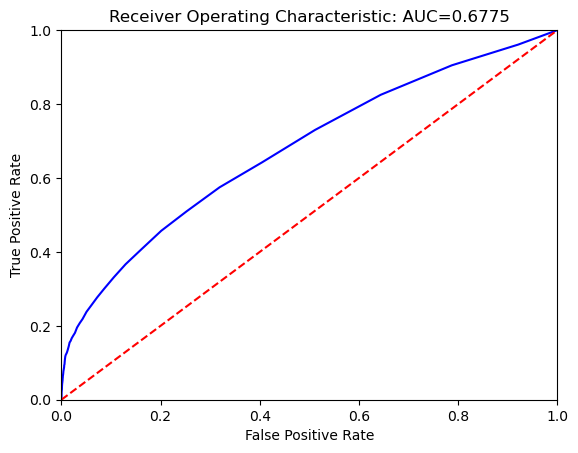

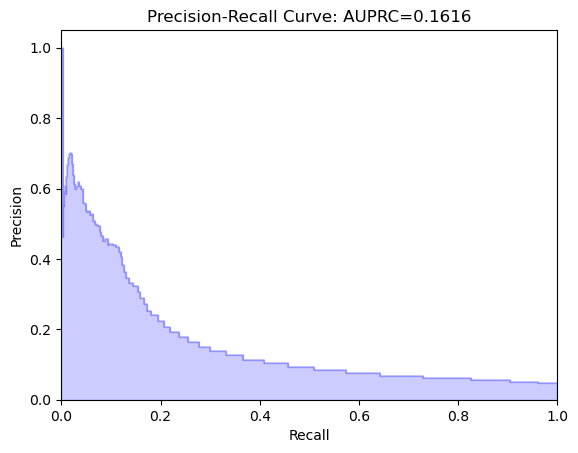

[0.00867458 0.04505499 0.01803913 0.02223026 0.02613355 0.00845095
 0.01035891 0.01686519 0.00098053 0.00174966 0.00352113 0.05609635
 0.04437533 0.04545058 0.02229662 0.02200421 0.04684079 0.04490259
 0.0035719  0.00234398 0.00437592 0.00124575 0.0030384  0.00519185
 0.00419468 0.00283198 0.00448617 0.0406744  0.04508931 0.02335059
 0.02292848 0.04518945 0.04459824 0.02164836 0.01691591 0.03080868
 0.01220693 0.01452483 0.00223349 0.00719966 0.00458424 0.00192079
 0.00119357 0.00036783 0.00231543 0.00140681 0.00137368 0.00010176
 0.00200469 0.00658276 0.0010499  0.00070132 0.00171026 0.00093421
 0.00110222 0.00056035 0.00295717 0.00346719 0.03456377 0.
 0.         0.0486218  0.01997802 0.01061183 0.0197958  0.01084003
 0.00969138 0.00888884]


In [ ]:
print("Random Forest")
rf= RandomForestClassifier(random_state=random_seed)
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
importances = rf.feature_importances_
print(importances)

results = ["RF"]
results.extend(result)
results.append(runtime)
result_listed_revisit_3d.append(results)

In [ ]:
importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
importance_df.to_csv(os.path.join(path, 'importances_72h_ed_revisit_disposition.csv'))
importance_df.sort_values(by='Importance', axis=0,ascending=False)

,Variable,Importance
11,ed_los_hours,0.056096
61,triage_MAP,0.048622
16,triage_sbp,0.046841
13,triage_heartrate,0.045451
31,ed_sbp_last,0.045189
28,ed_heartrate_last,0.045089
1,age,0.045055
17,triage_dbp,0.044903
32,ed_dbp_last,0.044598
12,triage_temperature,0.044375


## Gradient Boosting

GradientBoosting:
Training time: 97.16807198524475 seconds
AUC: 0.7010649514005867
AUPRC: 0.17082458970429817
Sensitivity: 0.6077425373134329
Specificity: 0.6873494119611632
Score thresold: 0.041765967982474665
2.5 97.5


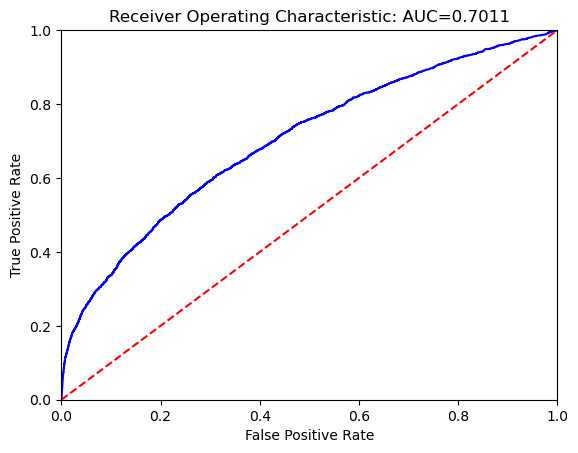

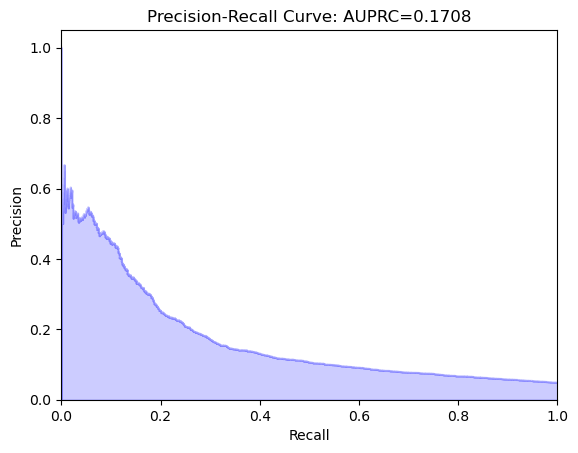

In [ ]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=random_seed)
start = time.time()
gb.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_listed_revisit_3d.append(results)

## Logistic Regression


Logistic Regression:


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 4.299292802810669 seconds
AUC: 0.6853607908713785
AUPRC: 0.16174059869471794
Sensitivity: 0.601679104477612
Specificity: 0.6660941339249504
Score thresold: 0.043084280280735306
2.5 97.5


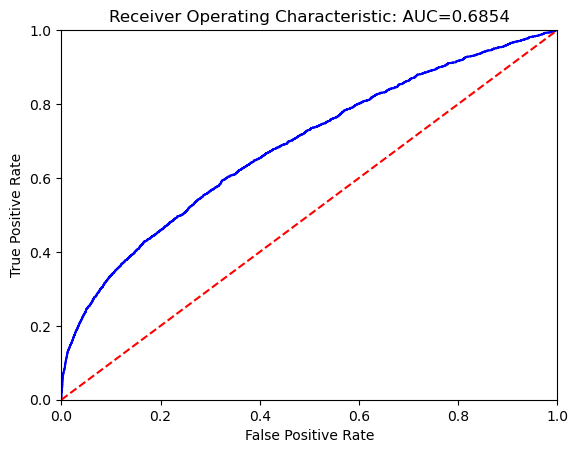

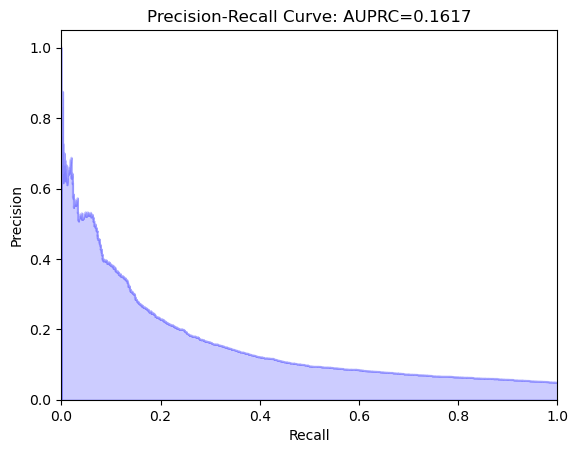

In [ ]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(random_state=random_seed)
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
import pickle
with open('task3_logreg.pickle', 'wb') as model_dump:
    pickle.dump(logreg, model_dump)
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1], y_test, ci=confidence_interval, random_seed=random_seed)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_listed_revisit_3d.append(results)

## Deep Learning

In [ ]:
#defines a custom neural network model using TensorFlow's Keras API
class MLP(tf.keras.Model):
    def __init__(self):
        super(MLP, self).__init__()
        self.dense_1 = Dense(128, activation='relu')
        self.dense_2 = Dense(64, activation='relu')
        self.classifier = Dense(1, activation='sigmoid')

    def call(self, x):
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.classifier(x)

In [ ]:
# skip this cell if not retraining
mlp = MLP()
mlp.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy', 'AUC', {'auprc': metrics.AUC(name='auprc', curve='PR')},
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train.astype(np.float32), y_train, batch_size=200, epochs=20)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')
mlp.save('72h_ed_revisit_mlp')

Epoch 1/20
882/882 [==============================] - 6s 4ms/step - loss: 0.3228 - accuracy: 0.9483 - auc: 0.6061 - auprc: 0.0958 - true_positives: 458.0000 - true_negatives: 166647.0000 - precision: 0.2827 - recall: 0.0545
Epoch 2/20
882/882 [==============================] - 3s 3ms/step - loss: 0.1968 - accuracy: 0.9517 - auc: 0.6215 - auprc: 0.1289 - true_positives: 421.0000 - true_negatives: 167289.0000 - precision: 0.4474 - recall: 0.0501
Epoch 3/20
882/882 [==============================] - 3s 4ms/step - loss: 0.1911 - accuracy: 0.9519 - auc: 0.6269 - auprc: 0.1300 - true_positives: 407.0000 - true_negatives: 167331.0000 - precision: 0.4599 - recall: 0.0484
Epoch 4/20
882/882 [==============================] - 4s 4ms/step - loss: 0.1893 - accuracy: 0.9520 - auc: 0.6326 - auprc: 0.1318 - true_positives: 383.0000 - true_negatives: 167379.0000 - precision: 0.4711 - recall: 0.0456
Epoch 5/20
882/882 [==============================] - 3s 4ms/step - loss: 0.1837 - accuracy: 0.9525 - au

INFO:tensorflow:Assets written to: hospitalization_triage_mlp\assets


MLP:
1377/1377 [==============================] - 3s 2ms/step
AUC: 0.6998792736560524
AUPRC: 0.17179401300956224
Sensitivity: 0.6142723880597015
Specificity: 0.6747536916434076
Score thresold: 0.03896535
2.5 97.5


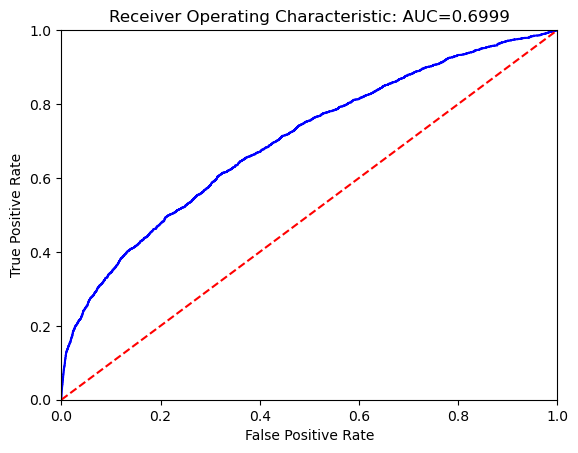

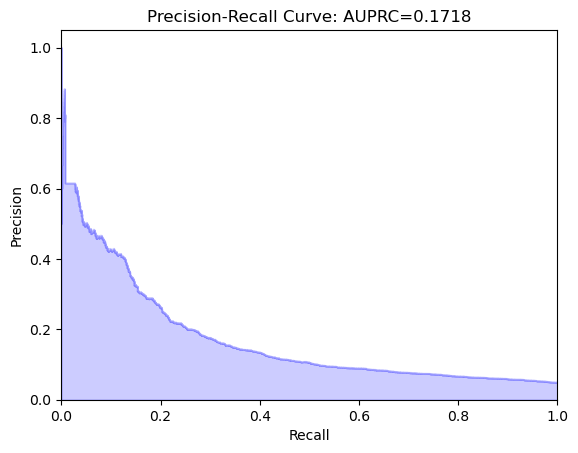

In [ ]:
print("MLP:")
mlp = load_model('72h_ed_revisit_mlp')
probs = mlp.predict(X_test.astype(np.float32))
result = PlotROCCurve(probs,y_test, ci=confidence_interval, random_seed=random_seed)
results = ["MLP"]
results.extend(result)
results.append(runtime)
result_listed_revisit_3d.append(results)

## Results Output

In [ ]:
result_df = pd.DataFrame(result_listed_revisit_3d, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
result_df.to_csv(os.path.join(path, 'result_72h_ed_revivist_disposition.csv'), index=False)
result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
formatted_result_df.to_csv(os.path.join(path, 'task3_19.csv'), index=False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,MLP,0.039,0.7 (0.69-0.712),0.172 (0.161-0.184),0.614 (0.606-0.659),0.675 (0.629-0.681),70.832


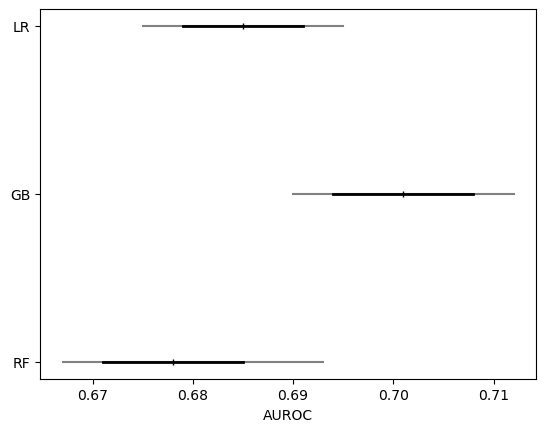

In [ ]:
#Plotting

from helpers import plot_confidence_interval
plot_confidence_interval(result_df, metric='auroc', ci=confidence_interval, name = "AUROC",
                         my_file = 'AUROC_72h.eps', my_path = output_path)


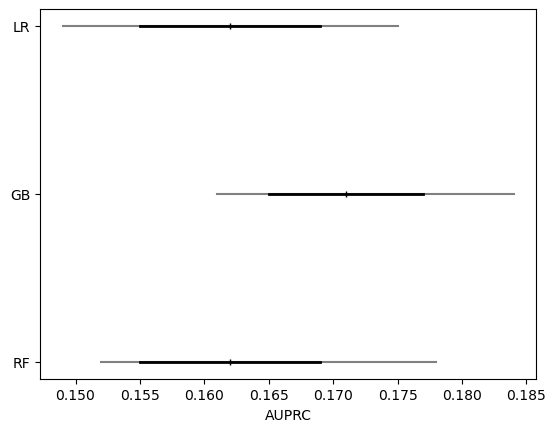

In [ ]:
plot_confidence_interval(result_df, metric='ap', ci=confidence_interval, name = "AUPRC",
                         my_file = 'AUPRC_72h.eps', my_path = output_path)